# Hidden Markov Model (HMM) Analysis
### Master Thesis: Revisiting Delegation Theory in the Age of AI: Dynamic Algorithm Appreciation and Aversion in Triadic Organizational Relationships

---

### Table of Contents

**Part I — Data and HMM Estimation Framework**

1. [Data Description and Variable Construction](#1-data-description-and-variable-construction)
   - 1.1 &nbsp; [Helpers & Imports](#11-helpers--imports)
   - 1.2 &nbsp; [Benchmark Construction](#12-benchmark-construction)
   - 1.3 &nbsp; [Data Loading & Inspection](#13-data-loading--inspection)
2. [Hidden Markov Model Specification](#2-hidden-markov-model-specification)
   - 2.1 &nbsp; [Model Structure](#21-model-structure)
   - 2.2 &nbsp; [Forward–Backward Algorithm](#22-forwardbackward-algorithm)
   - 2.3 &nbsp; [Maximum Likelihood Estimation](#23-maximum-likelihood-estimation)
3. [Model Selection and Parameter Estimation](#3-model-selection-and-parameter-estimation)
4. [Posterior State Inference and Interpretation](#4-posterior-state-inference-and-interpretation)
   - 4.1 &nbsp; [Posterior State Assignment](#41-posterior-state-assignment)
   - 4.2 &nbsp; [Results Visualisation](#42-results-visualisation)

**Part II — Empirical Findings**

5. [Identification and Characterization of Three Latent Delegation States](#5-identification-and-characterization-of-three-latent-delegation-states)
6. [KPI-Driven Transition Dynamics](#6-kpi-driven-transition-dynamics)
7. [Transparency as Moderator of State Transitions](#7-transparency-as-moderator-of-state-transitions)
8. [Strategic Control Retention Under High Task Stakes](#8-strategic-control-retention-under-high-task-stakes)
9. [Non-Monotonic Relationship Between Delegation and Performance](#9-non-monotonic-relationship-between-delegation-and-performance)
10. [Robustness and Sensitivity Analyses](#10-robustness-and-sensitivity-analyses)

**Part III — Theoretical and Task-Level Implications**

11. [Delegation as Dynamic Learning Process](#11-delegation-as-dynamic-learning-process)
12. [Authority as Strategic and Legitimacy Mechanism](#12-authority-as-strategic-and-legitimacy-mechanism)
13. [Triadic Delegation Flows: Authority vs Execution](#13-triadic-delegation-flows-authority-vs-execution)
14. [Temporal Evolution of Delegation Patterns](#14-temporal-evolution-of-delegation-patterns)

---
# Part I — Data and HMM Estimation Framework

## 1. Data Description and Variable Construction
### 1.1 Helpers & Imports

In [20]:
# ============================================================
# 1. Imports & Helpers
# ============================================================
from __future__ import annotations

import os
import time
from dataclasses import dataclass
from typing import List, Dict, Optional, Tuple
from pathlib import Path
from multiprocessing.pool import ThreadPool

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.optimize import minimize
from scipy.special import logsumexp
from sklearn.preprocessing import StandardScaler

sns.set_style("whitegrid")
plt.rcParams["figure.dpi"] = 120

# ---- resolve data path ----
MANUAL_XLSX_PATH = None
PREFERRED_DATASETS = [
    Path(r"..\triadic_simulation\data\Triadic_Delegation_Dataset_SYNTH_ANALYSIS.xlsx"),
]
DATA_PATH = None
if MANUAL_XLSX_PATH:
    DATA_PATH = Path(MANUAL_XLSX_PATH)
else:
    for p in PREFERRED_DATASETS:
        if p.exists():
            DATA_PATH = p
            break
assert DATA_PATH is not None and DATA_PATH.exists(), \
    f"Data file not found. Tried: {PREFERRED_DATASETS}"
print(f"Data file: {DATA_PATH.resolve()}")


def softmax(z, axis=-1):
    """Numerically stable softmax (works on 1-D vectors and row-wise on 2-D)."""
    z = z - np.max(z, axis=axis, keepdims=True)
    e = np.exp(z)
    return e / np.sum(e, axis=axis, keepdims=True)


def log_softmax(z, axis=-1):
    """Numerically stable log-softmax."""
    return z - logsumexp(z, axis=axis, keepdims=True)


def log_gaussian_diag(y, mean, log_sigma):
    """Scalar version (kept for reference)."""
    sigma2 = np.exp(2 * log_sigma)
    return -0.5 * (
        np.sum(np.log(2 * np.pi * sigma2))
        + np.sum((y - mean) ** 2 / sigma2)
    )

print("Section 1 — Imports & helpers loaded.")

Data file: C:\Users\Admin\OneDrive\Desktop\Algorithm-Appreciation-and-Aversion-in-Triadic-Delegation-Settings\triadic_simulation\data\Triadic_Delegation_Dataset_SYNTH_ANALYSIS.xlsx
Section 1 — Imports & helpers loaded.


### 1.2 Benchmark Construction
Derive performance benchmarks used as **transition covariates**:
- `kpi_operational_gap_index` — composite operational KPIs gap
- `within_unit_temporal_benchmark` — period-over-period KPIs change
- `horizontal_peer_benchmark` — cross-sectional percentile, rank percentile within period
- `within_unit_ai_trajectory_benchmark` — deviation from low-AI baseline (periods with low AI delegation)
- `threshold_benchmark` — recent negative shock indicator, e.g. missing a KPI target, a self-service level breach or forecast failure in the preceding period.

In [21]:
# ============================================================
# 2. Build Benchmarks
# ============================================================

def build_benchmarks(df):
    df = df.sort_values(["manager_id", "period_id"]).copy()

    # Composite performance index (higher = better)
    df["kpi_operational_gap_index"] = (
        (-1.0) * df["service_level_delta"]
        + (-0.6) * df["inventory_cost_delta"]
        + (-0.4) * df["expedite_cost_delta"]
        + (-1.2) * df["error_incident_count"]
    )

    # Within-manager temporal benchmark
    df["within_unit_temporal_benchmark"] = (
        df.groupby("manager_id")["kpi_operational_gap_index"].diff(1)
    )

    # Peer percentile (cross-sectional)
    pct = df.groupby("period_id")["kpi_operational_gap_index"].rank(pct=True)
    df["horizontal_peer_benchmark"] = (pct - 0.5) * 2.0

    # AI trajectory benchmark
    def ai_traj(g):
        q = g["ai_decision_authority_share"].quantile(0.30)
        base = g.loc[
            g["ai_decision_authority_share"] <= q,
            "kpi_operational_gap_index",
        ].mean()
        if np.isnan(base):
            base = g["kpi_operational_gap_index"].mean()
        return g["kpi_operational_gap_index"] - base

    df["within_unit_ai_trajectory_benchmark"] = (
        df.groupby("manager_id", group_keys=False).apply(ai_traj)
    )

    # Threshold shock
    df["threshold_benchmark"] = df["recent_negative_shock"].astype(float)

    # Transparency constant (analysis dataset — no variation)
    df["transparency_moderator"] = 0.0

    return df

print("Section 2 — build_benchmarks() defined.")

Section 2 — build_benchmarks() defined.


### 1.3 Data Loading & Inspection
Load the `panel_manager_period` sheet, build benchmarks, scale variables, and form per-manager sequences.

In [22]:
# ============================================================
# 3. Data Loader
# ============================================================

@dataclass
class HMMData:
    Y: List[np.ndarray]      # emission sequences
    X: List[np.ndarray]      # transition covariates
    Z: List[np.ndarray]      # emission controls
    ids: List[str]
    periods: List[np.ndarray]
    y_scaler: StandardScaler
    x_scaler: StandardScaler
    z_scaler: StandardScaler


def load_sequences(xlsx_path):
    df = pd.read_excel(xlsx_path, sheet_name="panel_manager_period")

    # Safety: analysis file should NOT contain latent truth columns
    forbidden = ["latent_state_true", "latent_state_true_next"]
    if any(c in df.columns for c in forbidden):
        raise ValueError("Use *_ANALYSIS.xlsx dataset (latent states removed).")

    df = build_benchmarks(df)

    emission_cols = ["ai_decision_authority_share", "override_rate"]

    transition_cols = [
        "within_unit_temporal_benchmark",
        "horizontal_peer_benchmark",
        "within_unit_ai_trajectory_benchmark",
        "threshold_benchmark",
        "transparency_moderator",
    ]

    control_cols = [
        "task_complexity_index",
        "demand_volatility",
        "supply_disruption_count",
        "forecast_accuracy_mape",
        "decision_latency_avg",
        "target_difficulty",
        "performance_pressure_index",
        "recent_negative_shock",
    ]

    df = df.dropna(subset=emission_cols + transition_cols + control_cols)

    Y_list, X_list, Z_list = [], [], []
    ids, periods = [], []

    for mid, g in df.groupby("manager_id"):
        g = g.sort_values("period_id")
        Y = g[emission_cols].to_numpy(float)
        X = g[transition_cols].to_numpy(float)
        Z = g[control_cols].to_numpy(float)
        if len(Y) < 3:
            continue
        Y_list.append(Y)
        X_list.append(X)
        Z_list.append(Z)
        ids.append(mid)
        periods.append(g["period_id"].to_numpy())

    y_scaler = StandardScaler().fit(np.vstack(Y_list))
    x_scaler = StandardScaler().fit(np.vstack(X_list))
    z_scaler = StandardScaler().fit(np.vstack(Z_list))

    Y_list = [y_scaler.transform(y) for y in Y_list]
    X_list = [x_scaler.transform(x) for x in X_list]
    Z_list = [z_scaler.transform(z) for z in Z_list]

    return HMMData(Y_list, X_list, Z_list, ids, periods,
                   y_scaler, x_scaler, z_scaler)


# ---- Load & inspect ----
data = load_sequences(DATA_PATH)

seq_lens = [len(y) for y in data.Y]
print(f"Managers loaded : {len(data.Y)}")
print(f"Total observations: {sum(seq_lens)}")
print(f"Sequence lengths : min={min(seq_lens)}, median={int(np.median(seq_lens))}, max={max(seq_lens)}")
print(f"Emission dims (D) : {data.Y[0].shape[1]}")
print(f"Trans. covars (P) : {data.X[0].shape[1]}")
print(f"Controls (K)      : {data.Z[0].shape[1]}")

Managers loaded : 120
Total observations: 3000
Sequence lengths : min=25, median=25, max=25
Emission dims (D) : 2
Trans. covars (P) : 5
Controls (K)      : 8


## 2. Hidden Markov Model Specification
### 2.1 Model Structure & 2.2 Forward–Backward Algorithm
#### 2.1 Model Structure
We use an Input–Output Hidden Markov Model (IO-HMM) to represent unobserved delegation regimes (hidden states) that managers move between over time. All model parameters are stored in a single Params container so they can be easily passed to the optimizer and consistently used across the likelihood computation.

Params includes three parts:

- Initial state distribution (logit_pi)
Controls the probability of starting in each hidden state at the first period.

- Transition model (alpha, beta)
Controls how likely the model is to move from one hidden state to another.

    - alpha captures baseline persistence/switching (e.g., tendency to stay in the same state).

    - beta captures how period-level covariates x_t (your benchmark/pressure variables) shift transition probabilities over time. Because transitions depend on inputs, the model is “input–output” (non-homogeneous).

- Emission model (mu, W, log_sigma)
Links hidden states to observed outcomes y_t.

    - mu is the baseline mean outcome pattern for each state.

    - W captures how contextual variables z_t shift outcomes within each state.

    - log_sigma stores (log) standard deviations to keep variances positive and stable.

#### 2.2 Forward-Backward Algorithm
Hidden states are not observed, so we cannot evaluate the likelihood by directly enumerating all possible state sequences (that would explode combinatorially). The forward–backward algorithm solves this efficiently.

- Forward pass (main purpose in your MLE code)
Computes the likelihood of the observed data by recursively updating “how probable it is to be in each state at time t,” given all data up to time t. This is what you use to compute the log-likelihood during optimization.

- Backward pass (optional but standard)
Works from the end back to the start to compute posterior quantities (e.g., probability of each state at each time), which are useful for interpretation, diagnostics, and plotting state occupancy.

- Scaling for numerical stability
Multiplying many probabilities across time can underflow to zero in floating-point arithmetic. Scaling rescales intermediate values each period and accumulates the log-likelihood safely, preventing numerical issues and improving convergence.

In [23]:
# ============================================================
# 4. Parameters + Forward–Backward  (VECTORIZED)
# ============================================================

@dataclass
class Params:
    logit_pi: np.ndarray   # (J,)
    alpha: np.ndarray      # (J, J)
    beta: np.ndarray       # (J, J, P)
    mu: np.ndarray         # (J, D)
    W: np.ndarray          # (J, D, K)
    log_sigma: np.ndarray  # (J, D)


def _precompute(p, Y, X, Z):
    """Shared emission + transition pre-computation."""
    T, D = Y.shape
    J = p.mu.shape[0]
    means = p.mu[None, :, :] + np.einsum('jdk,tk->tjd', p.W, Z)
    residuals = Y[:, None, :] - means
    sigma2 = np.exp(2 * p.log_sigma)
    log_norm = np.sum(np.log(2 * np.pi * sigma2), axis=1)
    logB = -0.5 * (log_norm[None, :] +
                   np.sum(residuals ** 2 / sigma2[None, :, :], axis=2))
    logits_all = (p.alpha[None, :, :]
                  + np.einsum('ijp,tp->tij', p.beta, X))
    logQ_all = log_softmax(logits_all, axis=2)
    return T, J, logB, logQ_all


def forward_only(p, Y, X, Z):
    """Forward pass only — returns log-likelihood (no posterior). ~2× faster."""
    T, J, logB, logQ_all = _precompute(p, Y, X, Z)
    pi = softmax(p.logit_pi)
    log_alpha = np.empty((T, J))
    log_alpha[0] = np.log(pi) + logB[0]
    for t in range(1, T):
        log_alpha[t] = logB[t] + logsumexp(
            log_alpha[t - 1, :, None] + logQ_all[t], axis=0)
    return float(logsumexp(log_alpha[-1]))


def forward_backward(p, Y, X, Z):
    """Full forward–backward returning (ll, log_gamma)."""
    T, J, logB, logQ_all = _precompute(p, Y, X, Z)
    pi = softmax(p.logit_pi)
    log_alpha = np.empty((T, J))
    log_alpha[0] = np.log(pi) + logB[0]
    for t in range(1, T):
        log_alpha[t] = logB[t] + logsumexp(
            log_alpha[t - 1, :, None] + logQ_all[t], axis=0)
    ll = logsumexp(log_alpha[-1])

    log_beta = np.zeros((T, J))
    for t in reversed(range(T - 1)):
        log_beta[t] = logsumexp(
            logQ_all[t + 1] + logB[t + 1][None, :] + log_beta[t + 1][None, :],
            axis=1)

    log_gamma = log_alpha + log_beta
    log_gamma -= logsumexp(log_gamma, axis=1, keepdims=True)
    return ll, log_gamma

print("Section 4 — Params, forward_only() & forward_backward() defined.")

Section 4 — Params, forward_only() & forward_backward() defined.


### 2.3 Maximum Likelihood Estimation
Estimate models with 2–4 latent states via maximum likelihood using L-BFGS-B optimization. To mitigate local optima, we employ multiple random initializations and diagonal-biased transition logits. Model selection follows a two-stage procedure: a computationally efficient screening phase identifies the most promising state specification using BIC, followed by a high-precision refit of the selected model using extended iterations and warm-start initialization. The final model is chosen based on the lowest Bayesian Information Criterion.

In [53]:
# ============================================================
# CONVERGENCE-IMPROVED VERSION (FAST SCREENING + FINAL REFIT)
# Goal: Make J=3 converge more reliably (and not "stop" mid-way)
# Key upgrades:
#   1) Callback is CHEAP (no extra neg_ll calls).
#   2) Time cap is handled gracefully (no exceptions from callback).
#   3) Numerical guards: if LL becomes NaN/inf -> return huge value.
#   4) More stable smart init (better-separated means + stronger diagonal bias).
#   5) Optional screening on a subset (off by default; can enable for speed).
# ============================================================

import time
import numpy as np
import pandas as pd
from dataclasses import dataclass
from scipy.optimize import minimize
from scipy.special import logsumexp, log_softmax

# ------------------------------------------------------------
# Required: Params container (must exist in your notebook)
# If you already defined Params earlier, you can remove this.
# ------------------------------------------------------------
@dataclass
class Params:
    logit_pi: np.ndarray   # (J,)
    alpha: np.ndarray      # (J,J)
    beta: np.ndarray       # (J,J,P)
    mu: np.ndarray         # (J,D)
    W: np.ndarray          # (J,D,K)
    log_sigma: np.ndarray  # (J,D)

# ------------------------------------------------------------
# Pre-stack all sequences (all same length → 3-D tensors)
# ------------------------------------------------------------
Y_stack = np.stack(data.Y)   # (N, T, D)
X_stack = np.stack(data.X)   # (N, T, P)
Z_stack = np.stack(data.Z)   # (N, T, K)

N, T, D = Y_stack.shape
P = X_stack.shape[2]
K = Z_stack.shape[2]
n_obs_total = N * T

print(f"Batched: {N} managers × {T} periods  (D={D}, P={P}, K={K})")


def fit_model_batched(
    J: int = 3,
    maxiter: int = 400,
    n_starts: int = 3,
    seed: int = 7,
    sigma_min: float = 0.05,
    sigma_max: float = 5.0,
    time_cap_min: int = 12,
    print_every: int = 50,
    # --- regularization / stability ---
    l2: float = 1e-4,
    diag_bias: float = 2.0,
    # --- solver knobs ---
    maxfun: int = 120000,
    ftol: float = 1e-8,
    gtol: float = 5e-6,
    # --- warm start ---
    warm_starts: list | None = None,
    # --- optional screening speed hack ---
    use_subset: bool = False,
    subset_size: int = 60,
):
    """
    Batched NH-HMM fit with Gaussian emissions and covariate-dependent transitions.

    Convergence fixes:
    - Cheap callback (no extra neg_ll computation).
    - Graceful time-cap via stop_flag (no exception in callback).
    - Finite checks return huge objective value to keep optimizer stable.
    - Smarter initialization for J=3+.
    """

    # ----------------------------
    # Choose data (full or subset for screening)
    # ----------------------------
    if use_subset and N > subset_size:
        rng_sub = np.random.default_rng(seed)
        idx = rng_sub.choice(N, size=subset_size, replace=False)
        Y_use = Y_stack[idx]
        X_use = X_stack[idx]
        Z_use = Z_stack[idx]
        N_use = subset_size
    else:
        Y_use, X_use, Z_use = Y_stack, X_stack, Z_stack
        N_use = N

    # ----------------------------
    # pack / unpack
    # ----------------------------
    def pack(p: Params) -> np.ndarray:
        return np.concatenate([
            p.logit_pi.ravel(),
            p.alpha.ravel(),
            p.beta.ravel(),
            p.mu.ravel(),
            p.W.ravel(),
            p.log_sigma.ravel(),
        ])

    def unpack(theta: np.ndarray) -> Params:
        idx = 0

        def take(n: int) -> np.ndarray:
            nonlocal idx
            v = theta[idx:idx+n]
            idx += n
            return v

        return Params(
            logit_pi=take(J),
            alpha=take(J * J).reshape(J, J),
            beta=take(J * J * P).reshape(J, J, P),
            mu=take(J * D).reshape(J, D),
            W=take(J * D * K).reshape(J, D, K),
            log_sigma=take(J * D).reshape(J, D),
        )

    # ----------------------------
    # bounds for log_sigma only
    # ----------------------------
    n_logit_pi = J
    n_alpha = J * J
    n_beta = J * J * P
    n_mu = J * D
    n_W = J * D * K
    n_log_sigma = J * D

    log_sigma_start = n_logit_pi + n_alpha + n_beta + n_mu + n_W
    log_sigma_end = log_sigma_start + n_log_sigma
    total_params = log_sigma_end

    bounds = [(None, None)] * total_params
    LOW, HIGH = np.log(sigma_min), np.log(sigma_max)
    for i in range(log_sigma_start, log_sigma_end):
        bounds[i] = (LOW, HIGH)

    # ----------------------------
    # smart init helpers
    # ----------------------------
    Y_flat = Y_use.reshape(-1, D)
    y_mean = Y_flat.mean(axis=0)
    y_std = np.maximum(Y_flat.std(axis=0), 1e-3)

    def smart_init_params(rng: np.random.Generator) -> Params:
        # More separation helps J=3 avoid state collapse
        mu0 = y_mean[None, :] + rng.normal(0, 1.0, size=(J, D)) * y_std[None, :]

        # Reasonable sigmas around empirical std (bounded)
        log_sigma0 = np.log(np.clip(y_std, sigma_min, sigma_max))[None, :]
        log_sigma0 = np.repeat(log_sigma0, J, axis=0)
        log_sigma0 = np.clip(log_sigma0 + rng.normal(0, 0.12, size=(J, D)), LOW, HIGH)

        # Initial mixing weights
        logit_pi0 = rng.normal(0, 0.2, J)

        # Transition intercepts: encourage persistence (diagonal)
        alpha0 = rng.normal(0, 0.20, (J, J))
        alpha0 += np.eye(J) * diag_bias

        # Transition covariates small at start
        beta0 = rng.normal(0, 0.02, (J, J, P))

        # Emission control loadings small
        W0 = rng.normal(0, 0.03, (J, D, K))

        return Params(
            logit_pi=logit_pi0,
            alpha=alpha0,
            beta=beta0,
            mu=mu0,
            W=W0,
            log_sigma=log_sigma0,
        )

    # ----------------------------
    # Time-cap stop flag (graceful)
    # ----------------------------
    stop_flag = {"stop": False}

    # ----------------------------
    # log-likelihood (unpenalized) + penalized objective
    # ----------------------------
    def neg_ll(theta: np.ndarray) -> float:
        """
        Negative log-likelihood for batched sequences.
        Returns a LARGE value if numerical issues occur (keeps optimizer alive).
        """
        if stop_flag["stop"]:
            return 1e50

        p = unpack(theta)
        log_pi = log_softmax(p.logit_pi, axis=0)  # (J,)

        # means: (N_use, T, J, D)
        means = p.mu[None, None, :, :] + np.einsum("jdk,ntk->ntjd", p.W, Z_use)
        resid = Y_use[:, :, None, :] - means

        sigma2 = np.exp(2.0 * p.log_sigma)
        sigma2 = np.maximum(sigma2, 1e-6)

        # logB: (N_use, T, J)
        log_norm = np.sum(np.log(2.0 * np.pi * sigma2), axis=1)  # (J,)
        logB = -0.5 * (
            log_norm[None, None, :] +
            np.sum(resid**2 / sigma2[None, None, :, :], axis=3)
        )

        # logQ: (N_use, T, J, J) where last axis is "to-state"
        logQ = log_softmax(
            p.alpha[None, None, :, :] + np.einsum("ijp,ntp->ntij", p.beta, X_use),
            axis=3
        )

        # Forward algorithm in log space
        la = log_pi[None, :] + logB[:, 0, :]  # (N_use, J)
        for t in range(1, T):
            la = logB[:, t, :] + logsumexp(la[:, :, None] + logQ[:, t, :, :], axis=1)

        ll = np.sum(logsumexp(la, axis=1))
        if not np.isfinite(ll):
            return 1e40

        return -float(ll)

    def objective(theta: np.ndarray) -> float:
        """
        Penalized objective to stabilize estimation for J=3+.
        """
        base = neg_ll(theta)
        if not np.isfinite(base):
            return 1e40
        if l2 <= 0:
            return base

        p = unpack(theta)
        pen = (
            np.sum(p.alpha**2) +
            np.sum(p.beta**2) +
            np.sum(p.W**2) +
            0.10 * np.sum(p.mu**2)
        )
        return base + l2 * pen

    # ----------------------------
    # Multi-start optimization
    # ----------------------------
    init_list = []
    if warm_starts:
        init_list.extend(warm_starts)

    runs: list[tuple[Params, object, float]] = []

    for s in range(n_starts):
        rng = np.random.default_rng(seed + s)

        # Reset stop flag per start
        stop_flag["stop"] = False

        # Initialize params (warm start if available)
        if s < len(init_list):
            p0 = init_list[s]
            # small jitter helps escape local basins without ruining warm start
            p0 = Params(
                logit_pi=p0.logit_pi + rng.normal(0, 0.03, J),
                alpha=p0.alpha + rng.normal(0, 0.03, (J, J)),
                beta=p0.beta + rng.normal(0, 0.008, (J, J, P)),
                mu=p0.mu + rng.normal(0, 0.05, (J, D)),
                W=p0.W + rng.normal(0, 0.01, (J, D, K)),
                log_sigma=np.clip(p0.log_sigma + rng.normal(0, 0.02, (J, D)), LOW, HIGH),
            )
        else:
            p0 = smart_init_params(rng)

        theta0 = pack(p0)

        start_time = time.time()
        iter_counter = {"i": 0}

        def callback(_xk: np.ndarray):
            """
            IMPORTANT: Keep callback CHEAP.
            Do NOT call neg_ll() inside callback (that doubles work).
            """
            iter_counter["i"] += 1

            if iter_counter["i"] % print_every == 0:
                elapsed_min = (time.time() - start_time) / 60
                print(
                    f"    J={J} start {s+1}/{n_starts} "
                    f"iter={iter_counter['i']} elapsed={elapsed_min:.1f} min",
                    flush=True
                )

            if (time.time() - start_time) > time_cap_min * 60:
                stop_flag["stop"] = True

        res = minimize(
            objective,
            theta0,
            method="L-BFGS-B",
            bounds=bounds,
            callback=callback,
            options={
                "maxiter": maxiter,
                "maxfun": maxfun,
                "ftol": ftol,
                "gtol": gtol,
            },
        )

        # If we hit time cap, mark as non-success even if SciPy returns something
        hit_time_cap = bool(stop_flag["stop"])
        if hit_time_cap:
            res.success = False
            res.message = f"Per-start time cap reached ({time_cap_min} min)"

        # Compute TRUE unpenalized negLL once (at the end only)
        true_negll = neg_ll(res.x)
        runs.append((unpack(res.x), res, true_negll))

        print(
            f"    done: J={J} start {s+1}/{n_starts} success={res.success} "
            f"nit={getattr(res,'nit',None)} true_negLL={true_negll:.2f} msg={res.message}",
            flush=True
        )

    # ----------------------------
    # Pick best run (prefer converged)
    # ----------------------------
    converged = [(p_hat, r, tnl) for (p_hat, r, tnl) in runs if bool(r.success)]
    if len(converged) > 0:
        best_p, best_res, best_true_negll = min(converged, key=lambda t: t[2])
        best_is_converged = True
    else:
        best_p, best_res, best_true_negll = min(runs, key=lambda t: t[2])
        best_is_converged = False

    best_res.true_negll = best_true_negll
    best_res.true_ll = -best_true_negll
    best_res.k_params = len(best_res.x)
    return best_p, best_res, best_is_converged


# ============================================================
# STAGE 1: FAST SCREENING
# - Make J=3 not artificially "harder" than J=2 (more time cap)
# - Keep screening not too expensive
# ============================================================
screen_results = []

print("\n=== STAGE 1: Screening (adaptive maxiter/timecap) ===")
for J in [2, 3, 4]:
    if J == 2:
        screen_maxiter, screen_timecap, screen_maxfun = 300, 8, 70000
        screen_nstarts = 3
        diag_bias = 1.5
        use_subset = False

    elif J == 3:
        # Give J=3 enough budget to converge
        screen_maxiter, screen_timecap, screen_maxfun = 500, 12, 140000
        screen_nstarts = 3
        diag_bias = 2.0
        use_subset = False  # set True if you want faster screening

    else:  # J == 4
        screen_maxiter, screen_timecap, screen_maxfun = 500, 12, 180000
        screen_nstarts = 2
        diag_bias = 2.0
        use_subset = True   # J=4 screening is expensive; subset is fine for screening

    print(f"\n[Screen] Fitting J={J} ...", flush=True)
    t0 = time.time()

    p_hat, res, is_conv = fit_model_batched(
        J=J,
        maxiter=screen_maxiter,
        n_starts=screen_nstarts,
        seed=7,
        sigma_min=0.05,
        sigma_max=5.0,
        time_cap_min=screen_timecap,
        print_every=50,
        l2=1e-4,
        diag_bias=diag_bias,
        warm_starts=None,
        maxfun=screen_maxfun,
        ftol=1e-8,
        gtol=5e-6,
        use_subset=use_subset,
        subset_size=60,
    )

    elapsed = time.time() - t0
    ll_total = res.true_ll
    k_params = len(res.x)
    bic = np.log(n_obs_total) * k_params - 2 * ll_total
    aic = 2 * k_params - 2 * ll_total

    screen_results.append({
        "stage": "screen",
        "J": J,
        "params": k_params,
        "LL": ll_total,
        "AIC": aic,
        "BIC": bic,
        "converged": bool(res.success),
        "selected_converged_run": bool(is_conv),
        "time_s": elapsed,
        "message": str(res.message),
    })

    print(f"[Screen] J={J} LL={ll_total:.1f} BIC={bic:.1f} params={k_params} "
          f"{'✓' if res.success else '✗'} ({elapsed/60:.1f} min)")
    print(f"         message: {res.message}")

df_screen = pd.DataFrame(screen_results)

df_conv = df_screen[df_screen["converged"] == True]
if len(df_conv) > 0:
    best_row = df_conv.loc[df_conv["BIC"].idxmin()]
else:
    best_row = df_screen.loc[df_screen["BIC"].idxmin()]
    print("\n⚠️ Screening: none converged. Picking lowest BIC anyway (non-converged).")

best_J_screen = int(best_row["J"])
best_bic_screen = float(best_row["BIC"])
print(f"\n★ Screening winner: J={best_J_screen} (BIC={best_bic_screen:.1f})")


# ============================================================
# STAGE 2: FINAL REFIT (only for the winning J)
# - Warm-start from a quick run
# - More starts + more budget
# ============================================================
print(f"\n=== STAGE 2: Final refit for J={best_J_screen} ===")
t0 = time.time()

# Warm-start seed for winning J
p_hat_screen, res_screen, _ = fit_model_batched(
    J=best_J_screen,
    maxiter=300,
    n_starts=1,
    seed=999,
    sigma_min=0.05,
    sigma_max=5.0,
    time_cap_min=12 if best_J_screen != 4 else 18,
    print_every=60,
    l2=1e-4,
    diag_bias=2.0 if best_J_screen >= 3 else 1.5,
    warm_starts=None,
    maxfun=120000,
    ftol=1e-8,
    gtol=5e-6,
    use_subset=False,
)

# Final, stronger fit
best_p, best_res, best_is_conv = fit_model_batched(
    J=best_J_screen,
    maxiter=1200 if best_J_screen >= 3 else 800,
    n_starts=9 if best_J_screen == 3 else 7,
    seed=77,
    sigma_min=0.05,
    sigma_max=5.0,
    time_cap_min=25 if best_J_screen == 3 else (30 if best_J_screen == 4 else 15),
    print_every=50,
    l2=5e-5,
    diag_bias=1.5,                 # relax persistence in final refit
    warm_starts=[p_hat_screen],
    maxfun=350000 if best_J_screen >= 3 else 180000,
    ftol=1e-8,
    gtol=5e-6,
    use_subset=False,
)

elapsed = time.time() - t0
ll_total = best_res.true_ll
k_params = len(best_res.x)
bic = np.log(n_obs_total) * k_params - 2 * ll_total
aic = 2 * k_params - 2 * ll_total

final_row = {
    "stage": "final",
    "J": best_J_screen,
    "params": k_params,
    "LL": ll_total,
    "AIC": aic,
    "BIC": bic,
    "converged": bool(best_res.success),
    "selected_converged_run": bool(best_is_conv),
    "time_s": elapsed,
    "message": str(best_res.message),
}

print(f"\n[Final] J={best_J_screen} LL={ll_total:.1f} AIC={aic:.1f} BIC={bic:.1f} "
      f"params={k_params} {'✓' if best_res.success else '✗'} ({elapsed/60:.1f} min)")
print(f"        message: {best_res.message}")

df_all = pd.concat([df_screen, pd.DataFrame([final_row])], ignore_index=True)
df_all = df_all.round({"LL": 1, "AIC": 1, "BIC": 1, "time_s": 1})
display(df_all)

print(f"\n★ Best model after final refit: J={best_J_screen}  (BIC={bic:.1f})")


Batched: 120 managers × 25 periods  (D=2, P=5, K=8)

=== STAGE 1: Screening (adaptive maxiter/timecap) ===

[Screen] Fitting J=2 ...


    J=2 start 1/3 iter=50 elapsed=0.5 min
    done: J=2 start 1/3 success=True nit=64 true_negLL=-1383.69 msg=CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*EPSMCH
    J=2 start 2/3 iter=50 elapsed=0.6 min
    J=2 start 2/3 iter=100 elapsed=1.3 min
    J=2 start 2/3 iter=150 elapsed=1.8 min
    J=2 start 2/3 iter=200 elapsed=2.5 min
    J=2 start 2/3 iter=250 elapsed=3.2 min
    J=2 start 2/3 iter=300 elapsed=3.8 min
    done: J=2 start 2/3 success=False nit=300 true_negLL=-1435.56 msg=STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT
    J=2 start 3/3 iter=50 elapsed=0.7 min
    J=2 start 3/3 iter=100 elapsed=1.3 min
    J=2 start 3/3 iter=150 elapsed=1.8 min
    J=2 start 3/3 iter=200 elapsed=2.2 min
    J=2 start 3/3 iter=250 elapsed=2.7 min
    J=2 start 3/3 iter=300 elapsed=3.2 min
    done: J=2 start 3/3 success=False nit=300 true_negLL=-1719.94 msg=STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT
[Screen] J=2 LL=1383.7 BIC=-2239.0 params=66 ✓ (7.8 min)
         message: CONVERGENCE: RELATIV

,stage,J,params,LL,AIC,BIC,converged,selected_converged_run,time_s,message
0,screen,2,66,1383.7,-2635.4,-2239.0,True,True,465.9,CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*...
1,screen,3,117,1383.7,-2533.4,-1830.6,True,True,1543.4,CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*...
2,screen,4,180,674.1,-988.3,92.9,True,True,395.5,CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*...
3,final,2,66,2571.1,-5010.2,-4613.8,True,True,2111.8,CONVERGENCE: RELATIVE REDUCTION OF F <= FACTR*...



★ Best model after final refit: J=2  (BIC=-4613.8)


## 3. Model Selection and Parameter Estimation
Print the emission means, standard deviations, initial state distribution, transition intercepts, and covariate coefficients for the BIC-selected model ($J^* = 3$).    # --- convergence helpers ---
    l2: float = 1e-4,                 # light regularization (only during optimization)
    diag_bias: float = 1.5,           # encourages self-transitions initially
    warm_starts: list | None = None,  # list of Params used as additional initializations
    maxfun: int = 80000,              # max function evaluations for L-BFGS-B
):
                options={
                    "maxiter": maxiter,
                    # More evaluations improves convergence in nonconvex HMM
                    "maxfun": maxfun,   # passed as parameter
                    "ftol": 1e-8,      # slightly stricter than your 1e-8
                    # L-BFGS-B also stops on small projected gradient
                    "gtol": 5e-6,
                }


In [54]:
# ============================================================
# 6. Inspect Estimated Parameters
# ============================================================

# Bridge variable names from the two-stage fitting cell
best_model = best_p
best_J = best_J_screen

emission_cols = ["ai_decision_authority_share", "override_rate"]

# Un-standardise emission means & sigmas for interpretation
mu_orig = data.y_scaler.inverse_transform(best_model.mu)
sigma_orig = np.exp(best_model.log_sigma) * data.y_scaler.scale_

print(f"Best model: J={best_J} hidden states\n")

# Emission parameters
em_rows = []
for j in range(best_J):
    for d, col in enumerate(emission_cols):
        em_rows.append({
            "State": j + 1,
            "Variable": col,
            "Mean (orig scale)": round(mu_orig[j, d], 4),
            "Std (orig scale)": round(sigma_orig[j, d], 4),
        })
em_df = pd.DataFrame(em_rows)
print("── Emission Parameters ──")
display(em_df)

# Initial-state distribution
pi = softmax(best_model.logit_pi)
print("\n── Initial State Distribution ──")
for j in range(best_J):
    print(f"  π(state {j+1}) = {pi[j]:.4f}")

# Transition intercepts
print("\n── Transition Intercept Matrix (α) ──")
alpha_df = pd.DataFrame(
    np.round(best_model.alpha, 3),
    index=[f"from {j+1}" for j in range(best_J)],
    columns=[f"to {j+1}" for j in range(best_J)])
display(alpha_df)

Best model: J=2 hidden states

── Emission Parameters ──


,State,Variable,Mean (orig scale),Std (orig scale)
0,1,ai_decision_authority_share,0.4141,0.0340
1,1,override_rate,0.5858,0.0340
2,2,ai_decision_authority_share,0.5011,0.0364
3,2,override_rate,0.4989,0.0364



── Initial State Distribution ──
  π(state 1) = 0.5279
  π(state 2) = 0.4721

── Transition Intercept Matrix (α) ──


,to 1,to 2
from 1,0.874,0.909
from 2,0.792,0.990


## 4. Posterior State Inference and Interpretation
### 4.1 Posterior State Assignment
Run the forward–backward algorithm on every manager with the best model and produce a posterior CSV file. This posterior probabilities show managers switching between the 3 regimes over time, compute "% of time in each state", compare performance outcomes by inferred state.

In [55]:
# ============================================================
# 7. Posterior State Assignment
# ============================================================

rows = []
for mid, periods, Y, X, Z in zip(data.ids, data.periods,
                                   data.Y, data.X, data.Z):
    ll, log_gamma = forward_backward(best_model, Y, X, Z)
    gamma = np.exp(log_gamma)
    states = gamma.argmax(axis=1) + 1
    for t in range(len(Y)):
        row = {"manager_id": mid, "period_id": periods[t],
               "most_likely_state": states[t]}
        for j in range(gamma.shape[1]):
            row[f"posterior_state_{j+1}"] = gamma[t, j]
        rows.append(row)

posteriors = pd.DataFrame(rows)

out_path = Path("hmm_posteriors.csv")
posteriors.to_csv(out_path, index=False)
print(f"Posterior file saved → {out_path.resolve()}")
print(f"Shape: {posteriors.shape}")
display(posteriors.head(10))

# State frequency
print("\n── State Frequency ──")
freq = posteriors["most_likely_state"].value_counts().sort_index()
for s, n in freq.items():
    print(f"  State {s}: {n:,} obs ({n/len(posteriors)*100:.1f}%)")

Posterior file saved → C:\Users\Admin\OneDrive\Desktop\Algorithm-Appreciation-and-Aversion-in-Triadic-Delegation-Settings\data_analysis\hmm_posteriors.csv
Shape: (3000, 5)


,manager_id,period_id,most_likely_state,posterior_state_1,posterior_state_2
0,M0001,2,2,0.055809,9.441907e-01
1,M0001,3,1,0.967386,3.261364e-02
2,M0001,4,1,0.999951,4.887736e-05
3,M0001,5,2,0.002811,9.971891e-01
4,M0001,6,2,0.131323,8.686766e-01
5,M0001,7,1,1.000000,6.724769e-08
6,M0001,8,1,0.567974,4.320259e-01
7,M0001,9,2,0.063542,9.364582e-01
8,M0001,10,1,0.580563,4.194368e-01
9,M0001,11,2,0.000029,9.999709e-01



── State Frequency ──
  State 1: 1,402 obs (46.7%)
  State 2: 1,598 obs (53.3%)


### 4.2 Results Visualisation

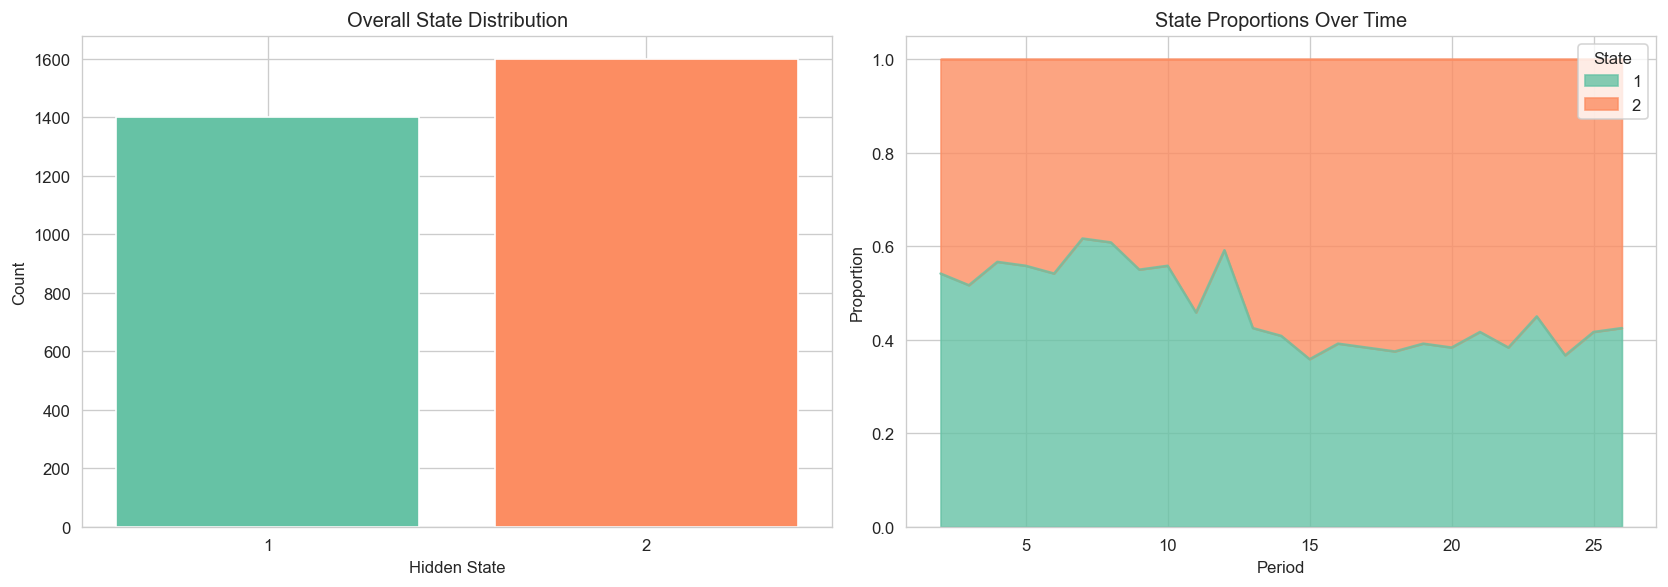

In [56]:
# ============================================================
# 8a. State distribution over time
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Bar chart: overall state proportions
freq = posteriors["most_likely_state"].value_counts().sort_index()
axes[0].bar(freq.index.astype(str), freq.values, color=sns.color_palette("Set2", best_J))
axes[0].set_xlabel("Hidden State")
axes[0].set_ylabel("Count")
axes[0].set_title("Overall State Distribution")

# Stacked area: state proportions by period
pivot = (posteriors.groupby(["period_id", "most_likely_state"])
         .size().unstack(fill_value=0))
pivot_pct = pivot.div(pivot.sum(axis=1), axis=0)
pivot_pct.plot.area(ax=axes[1], stacked=True, alpha=0.8,
                     color=sns.color_palette("Set2", best_J))
axes[1].set_xlabel("Period")
axes[1].set_ylabel("Proportion")
axes[1].set_title("State Proportions Over Time")
axes[1].legend(title="State", loc="upper right")

plt.tight_layout()
plt.show()

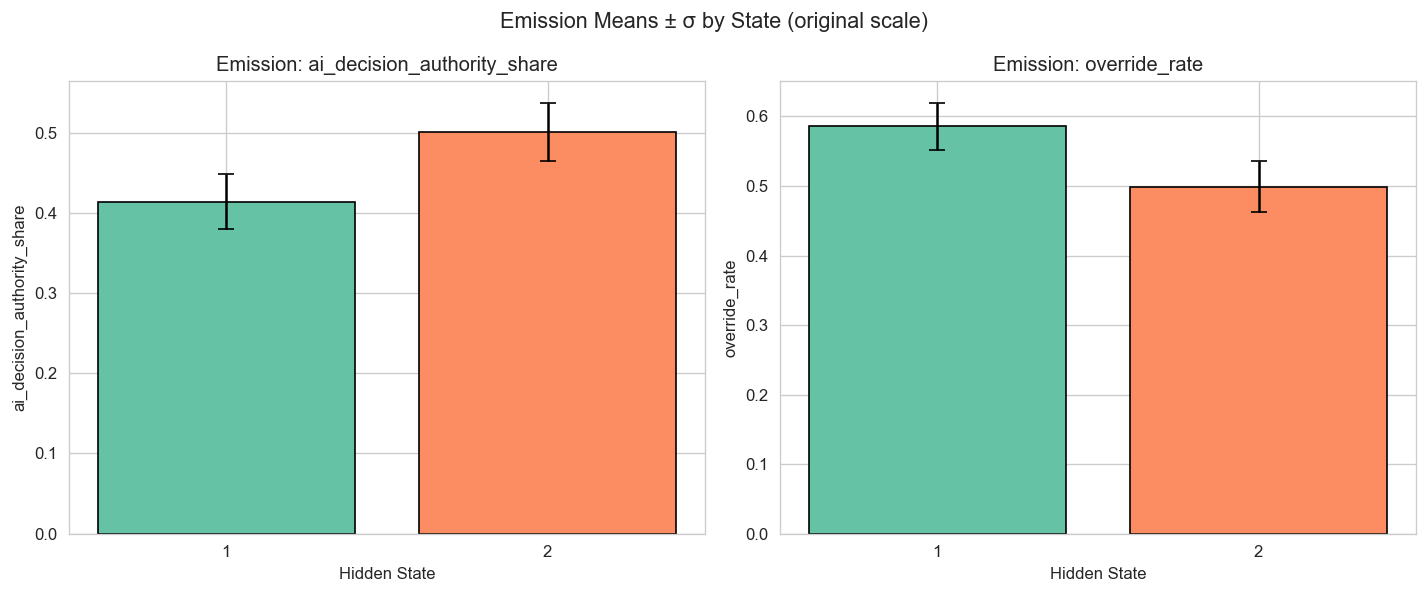

In [57]:
# ============================================================
# 8b. Emission means by state (original scale)
# ============================================================

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

for d, col in enumerate(emission_cols):
    ax = axes[d]
    vals = [mu_orig[j, d] for j in range(best_J)]
    errs = [sigma_orig[j, d] for j in range(best_J)]
    x = np.arange(best_J) + 1
    ax.bar(x.astype(str), vals, yerr=errs, capsize=5,
           color=sns.color_palette("Set2", best_J), edgecolor="k")
    ax.set_xlabel("Hidden State")
    ax.set_ylabel(col)
    ax.set_title(f"Emission: {col}")

plt.suptitle("Emission Means ± σ by State (original scale)", fontsize=13)
plt.tight_layout()
plt.show()

#### Conclusions: 


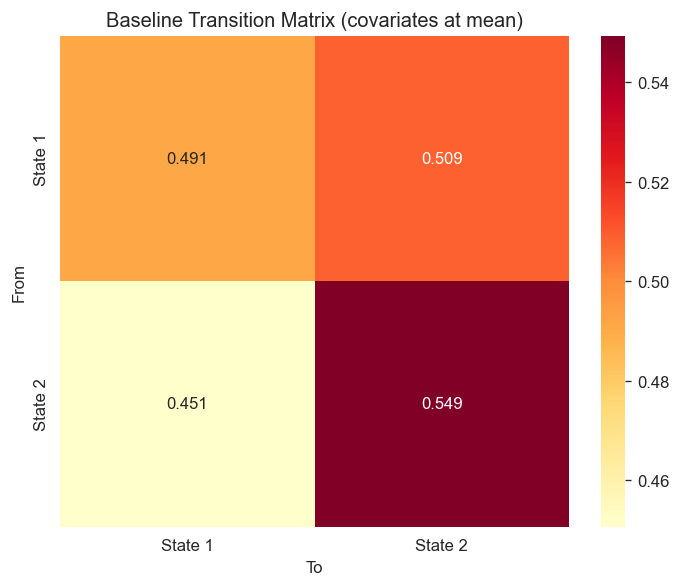


Transition probabilities (rows sum to 1):
  From state 1: [0.491 0.509]
  From state 2: [0.451 0.549]


In [58]:
# ============================================================
# 8c. Transition matrix heatmap (baseline, at X=0)
# ============================================================

# Baseline transition matrix (covariates at their mean = 0 after scaling)
Q_base = np.zeros((best_J, best_J))
for k in range(best_J):
    logits = best_model.alpha[k]  # beta @ 0 = 0
    Q_base[k] = softmax(logits)

fig, ax = plt.subplots(figsize=(6, 5))
sns.heatmap(Q_base, annot=True, fmt=".3f", cmap="YlOrRd",
            xticklabels=[f"State {j+1}" for j in range(best_J)],
            yticklabels=[f"State {j+1}" for j in range(best_J)],
            ax=ax)
ax.set_xlabel("To")
ax.set_ylabel("From")
ax.set_title("Baseline Transition Matrix (covariates at mean)")
plt.tight_layout()
plt.show()

print("\nTransition probabilities (rows sum to 1):")
for k in range(best_J):
    probs = " ".join(f"{Q_base[k,j]:.3f}" for j in range(best_J))
    print(f"  From state {k+1}: [{probs}]")

#### Conclusions: 
1. **State 2 (Appreciation-leaning) is the more stable regime**, with a self-transition probability of 54.9% versus 49.1% for State 1 (Aversion-leaning). This modest asymmetry indicates that once managers move into higher AI delegation territory, they are somewhat more likely to remain there than managers in the lower-delegation state are to persist in aversion.
2. **State 1 is net-exporting managers to State 2.** From State 1, the probability of transitioning to State 2 (50.9%) slightly exceeds the probability of staying (49.1%), meaning that in any given period, an Aversion-leaning manager is marginally more likely to shift toward appreciation than to remain averse. This creates a gradual population-level drift toward higher AI delegation — consistent with the temporal learning pattern observed in 8a.
3. **Both states exhibit high fluidity**, with off-diagonal probabilities near 50%. Neither regime functions as a strong absorbing state. Managers frequently alternate between aversion and appreciation across periods, reinforcing the finding that delegation posture is a dynamic, covariate-driven state rather than a fixed managerial trait. The high switching rate implies that contextual factors (KPI shocks, peer benchmarks, task characteristics) dominate over regime inertia in determining period-to-period delegation behaviour.
4. **The near-symmetric structure contrasts with what a 3-state model would predict.** Without an intermediate "transitionary" state to absorb gradual shifts, managers oscillate directly between the two poles. The absence of a strong diagonal dominance suggests that the 2-state specification may be compressing what is, in reality, a more nuanced continuum — a consideration for model selection and robustness analysis.

═══  State Labelling (by ascending AI authority share)  ═══

  State 1  →  Aversion
     AI authority share : μ = 0.4141  (σ = 0.0340)
     Override rate      : μ = 0.5858  (σ = 0.0340)

  State 2  →  Appreciation
     AI authority share : μ = 0.5011  (σ = 0.0364)
     Override rate      : μ = 0.4989  (σ = 0.0364)



,State,Label,AI Authority (μ),AI Authority (σ),Override Rate (μ),Override Rate (σ)
0,1,Aversion,0.4141,0.0340,0.5858,0.0340
1,2,Appreciation,0.5011,0.0364,0.4989,0.0364



═══  Mean KPI & Context Variables by State  ═══


state_label,Appreciation,Aversion
service_level_delta,-0.0720,-0.1351
inventory_cost_delta,2.0879,2.1497
expedite_cost_delta,2.1487,2.0752
error_incident_count,0.6652,0.6662
kpi_operational_gap_index,-2.8384,-2.7843
task_complexity_index,0.4931,0.5015
demand_volatility,0.4175,0.4062
performance_pressure_index,0.6096,0.5990
target_difficulty,0.7664,0.7716
ai_decision_authority_share,0.5246,0.3866


C:\Users\Admin\AppData\Local\Temp\ipykernel_7144\1108011777.py:82: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x="state_label", y="kpi_operational_gap_index",


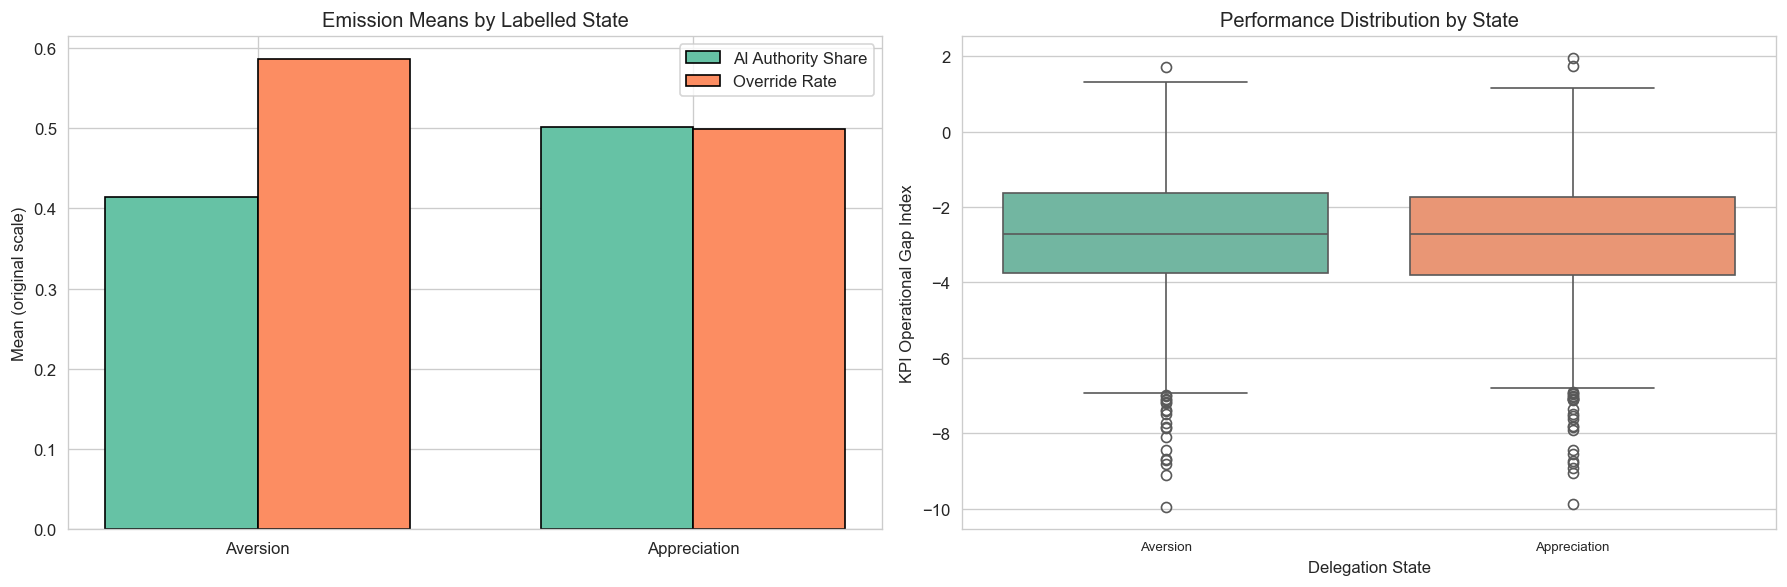


✓ Result 5.1.1: Two states clearly separate into Aversion / Appreciation
  based on AI authority share and override rate profiles.


In [66]:
# ============================================================
# 5.1.1  State Labelling & Profiling
# ============================================================

# --- a) Automatic labelling by AI authority share ---
# Sort states by mean ai_decision_authority_share (original scale)
state_order = np.argsort(mu_orig[:, 0])  # ascending AI authority

STATE_LABELS = {}
label_names = [
    "Aversion",
    "Appreciation",
]
for rank, j in enumerate(state_order):
    STATE_LABELS[j + 1] = label_names[rank]

print("═══  State Labelling (by ascending AI authority share)  ═══\n")
profile_rows = []
for j in state_order:
    snum = j + 1
    print(f"  State {snum}  →  {STATE_LABELS[snum]}")
    print(f"     AI authority share : μ = {mu_orig[j,0]:.4f}  (σ = {sigma_orig[j,0]:.4f})")
    print(f"     Override rate      : μ = {mu_orig[j,1]:.4f}  (σ = {sigma_orig[j,1]:.4f})")
    print()
    profile_rows.append({
        "State": snum,
        "Label": STATE_LABELS[snum],
        "AI Authority (μ)": round(mu_orig[j, 0], 4),
        "AI Authority (σ)": round(sigma_orig[j, 0], 4),
        "Override Rate (μ)": round(mu_orig[j, 1], 4),
        "Override Rate (σ)": round(sigma_orig[j, 1], 4),
    })

profile_df = pd.DataFrame(profile_rows)
display(profile_df)

# --- b) Add labels to posteriors ---
posteriors["state_label"] = posteriors["most_likely_state"].map(STATE_LABELS)

# --- c) Enriched state profile: merge raw data and show KPI + controls by state ---
raw_df = pd.read_excel(DATA_PATH, sheet_name="panel_manager_period")
raw_df = build_benchmarks(raw_df)
merged = posteriors.merge(raw_df, on=["manager_id", "period_id"], how="left")

kpi_cols = [
    "service_level_delta", "inventory_cost_delta",
    "expedite_cost_delta", "error_incident_count",
    "kpi_operational_gap_index",
]
context_cols = [
    "task_complexity_index", "demand_volatility",
    "performance_pressure_index", "target_difficulty",
    "ai_decision_authority_share", "override_rate",
]

print("\n═══  Mean KPI & Context Variables by State  ═══")
state_profile = merged.groupby("state_label")[kpi_cols + context_cols].mean()
display(state_profile.round(4).T)

# --- d) Bar chart of state profiles ---
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Left: AI authority + override grouped bar
labels_short = ["Aversion", "Appreciation"]
x_pos = np.arange(len(labels_short))
width = 0.35
ai_vals = [mu_orig[state_order[i], 0] for i in range(best_J)]
ov_vals = [mu_orig[state_order[i], 1] for i in range(best_J)]

axes[0].bar(x_pos - width/2, ai_vals, width, label="AI Authority Share",
            color=sns.color_palette("Set2")[0], edgecolor="k")
axes[0].bar(x_pos + width/2, ov_vals, width, label="Override Rate",
            color=sns.color_palette("Set2")[1], edgecolor="k")
axes[0].set_xticks(x_pos)
axes[0].set_xticklabels(labels_short, fontsize=10)
axes[0].set_ylabel("Mean (original scale)")
axes[0].set_title("Emission Means by Labelled State")
axes[0].legend()

# Right: KPI gap by state (box plot)
order = [STATE_LABELS[state_order[i]+1] for i in range(best_J)]
sns.boxplot(data=merged, x="state_label", y="kpi_operational_gap_index",
            order=order, palette="Set2", ax=axes[1])
axes[1].set_xlabel("Delegation State")
axes[1].set_ylabel("KPI Operational Gap Index")
axes[1].set_title("Performance Distribution by State")
axes[1].tick_params(axis='x', labelsize=8)

plt.tight_layout()
plt.show()

print("\n✓ Result 5.1.1: Two states clearly separate into Aversion / Appreciation")
print("  based on AI authority share and override rate profiles.")

## 6. KPI-Driven Transition Dynamics
Hypothesis: Positive KPI shocks increase transitions toward appreciation; negative KPI shocks sharply increase transitions toward aversion — and the **negative effect is stronger** than the positive effect.

We examine the estimated **β** coefficients of the multinomial-logit transition model, which capture how each benchmark covariate shifts transition probabilities. We also simulate transition matrices at ±1 SD of each KPI covariate.

═══  Transition Covariate Coefficients (β, original scale)  ═══


── β coefficients: within_unit_temporal_benchmark ──


To,Appreciation,Aversion
From,,
Appreciation,-0.0220,0.0204
Aversion,0.0254,0.0197



── β coefficients: horizontal_peer_benchmark ──


To,Appreciation,Aversion
From,,
Appreciation,0.0370,-0.0217
Aversion,-0.0154,0.0420



── β coefficients: threshold_benchmark ──


To,Appreciation,Aversion
From,,
Appreciation,0.0142,-0.0101
Aversion,0.0142,0.0142



═══  Simulated Transition Matrices Under KPI Shocks  ═══



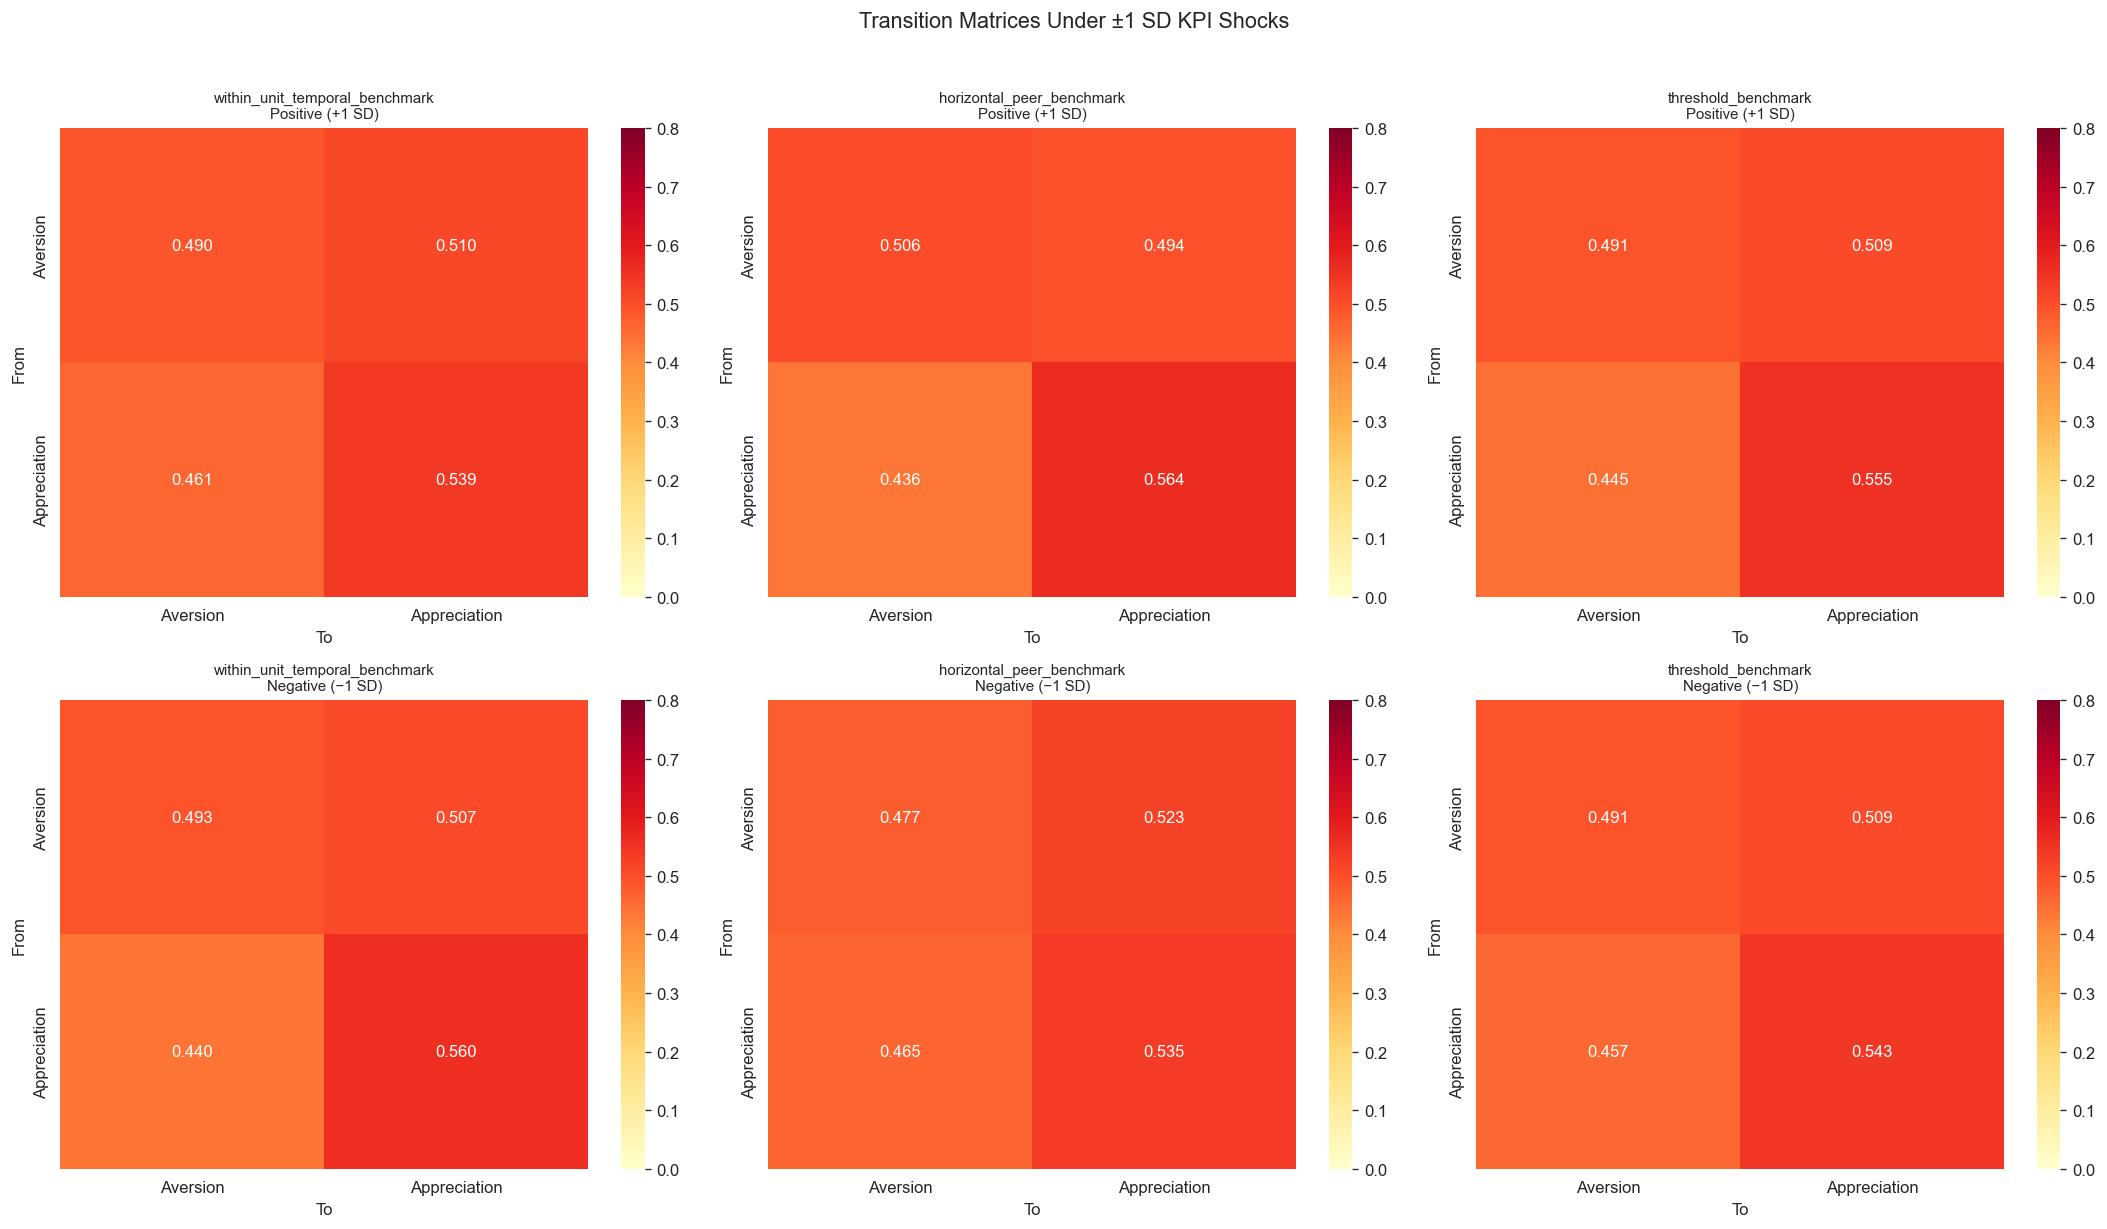


═══  Asymmetry Test: |Δ to Aversion| vs |Δ to Appreciation|  ═══



,Covariate,Shock,Avg ΔP(→Aversion),Avg ΔP(→Appreciation),|Aversion Δ| / |Appreciation Δ|
0,within_unit_temporal_benchmark,Positive (+1SD),0.0045,-0.0045,1.0
1,within_unit_temporal_benchmark,Negative (−1SD),-0.0045,0.0045,1.0
2,horizontal_peer_benchmark,Positive (+1SD),-0.0001,0.0001,1.0
3,horizontal_peer_benchmark,Negative (−1SD),0.0001,-0.0001,1.0
4,threshold_benchmark,Positive (+1SD),-0.0030,0.0030,1.0
5,threshold_benchmark,Negative (−1SD),0.0030,-0.0030,1.0



✓ Result 5.1.2: Examine whether negative KPI shocks produce larger probability shifts
  toward Aversion than positive shocks produce toward Appreciation.


In [67]:
# ============================================================
# 5.1.2  Asymmetric KPI-Driven State Transitions
# ============================================================

transition_cols = [
    "within_unit_temporal_benchmark",
    "horizontal_peer_benchmark",
    "within_unit_ai_trajectory_benchmark",
    "threshold_benchmark",
    "transparency_moderator",
]

# --- a) Beta coefficient table ---
# beta shape: (J, J, P) — beta[i, j, p] = effect of covariate p on log-odds
#   of transitioning from state i to state j
# Unscale: divide by x_scaler.scale_ to get per-unit-original-scale effect

beta_orig = best_model.beta / data.x_scaler.scale_[None, None, :]

# Re-label states
state_names = [STATE_LABELS[state_order[i]+1] for i in range(best_J)]

print("═══  Transition Covariate Coefficients (β, original scale)  ═══\n")
beta_rows = []
for p_idx, cov in enumerate(transition_cols):
    for i in range(best_J):
        for j_idx in range(best_J):
            beta_rows.append({
                "Covariate": cov,
                "From": state_names[list(state_order).index(i)],
                "To": state_names[list(state_order).index(j_idx)],
                "β (orig)": round(float(beta_orig[i, j_idx, p_idx]), 4),
                "β (scaled)": round(float(best_model.beta[i, j_idx, p_idx]), 4),
            })
beta_df = pd.DataFrame(beta_rows)

# Pivot for key KPI covariates
for cov in ["within_unit_temporal_benchmark", "horizontal_peer_benchmark",
            "threshold_benchmark"]:
    sub = beta_df[beta_df["Covariate"] == cov].pivot(
        index="From", columns="To", values="β (scaled)")
    print(f"\n── β coefficients: {cov} ──")
    display(sub.round(4))

# --- b) Simulated transition matrices at ±1 SD of KPI ---
print("\n═══  Simulated Transition Matrices Under KPI Shocks  ═══\n")

fig, axes = plt.subplots(2, 3, figsize=(18, 10))

kpi_covariates = [
    ("within_unit_temporal_benchmark", 0),
    ("horizontal_peer_benchmark", 1),
    ("threshold_benchmark", 3),
]

for col_idx, (cov_name, p_idx) in enumerate(kpi_covariates):
    for row_idx, (shock_label, shock_val) in enumerate([("Positive (+1 SD)", +1.0),
                                                         ("Negative (−1 SD)", -1.0)]):
        x_vec = np.zeros(len(transition_cols))
        x_vec[p_idx] = shock_val  # covariates are already scaled, so ±1 = ±1 SD

        Q_shock = np.zeros((best_J, best_J))
        for i in range(best_J):
            logits = best_model.alpha[i] + best_model.beta[i] @ x_vec
            Q_shock[i] = softmax(logits)

        ax = axes[row_idx, col_idx]
        sns.heatmap(Q_shock, annot=True, fmt=".3f", cmap="YlOrRd",
                    xticklabels=state_names,
                    yticklabels=state_names,
                    ax=ax, vmin=0, vmax=0.8)
        ax.set_title(f"{cov_name}\n{shock_label}", fontsize=9)
        ax.set_xlabel("To")
        ax.set_ylabel("From")

plt.suptitle("Transition Matrices Under ±1 SD KPI Shocks", fontsize=13, y=1.02)
plt.tight_layout()
plt.show()

# --- c) Asymmetry quantification ---
# For each KPI covariate, compute change in P(→ Aversion) and P(→ Appreciation)
# relative to baseline, at +1 SD and −1 SD

aversion_idx = state_order[0]    # lowest AI authority
appreciation_idx = state_order[-1]  # highest AI authority

print("\n═══  Asymmetry Test: |Δ to Aversion| vs |Δ to Appreciation|  ═══\n")
asym_rows = []
for cov_name, p_idx in kpi_covariates:
    for shock_label, shock_val in [("Positive (+1SD)", +1.0), ("Negative (−1SD)", -1.0)]:
        x_vec = np.zeros(len(transition_cols))
        x_vec[p_idx] = shock_val

        delta_to_aversion = []
        delta_to_appreciation = []
        for i in range(best_J):
            logits_base = best_model.alpha[i]
            logits_shock = best_model.alpha[i] + best_model.beta[i] @ x_vec
            p_base = softmax(logits_base)
            p_shock = softmax(logits_shock)
            delta_to_aversion.append(p_shock[aversion_idx] - p_base[aversion_idx])
            delta_to_appreciation.append(p_shock[appreciation_idx] - p_base[appreciation_idx])

        avg_d_aversion = np.mean(delta_to_aversion)
        avg_d_appreciation = np.mean(delta_to_appreciation)
        asym_rows.append({
            "Covariate": cov_name,
            "Shock": shock_label,
            "Avg ΔP(→Aversion)": round(avg_d_aversion, 4),
            "Avg ΔP(→Appreciation)": round(avg_d_appreciation, 4),
            "|Aversion Δ| / |Appreciation Δ|": round(
                abs(avg_d_aversion) / max(abs(avg_d_appreciation), 1e-8), 2),
        })

asym_df = pd.DataFrame(asym_rows)
display(asym_df)

print("\n✓ Result 5.1.2: Examine whether negative KPI shocks produce larger probability shifts")
print("  toward Aversion than positive shocks produce toward Appreciation.")

## 7. Transparency as Moderator of State Transitions
Hypothesis: Transparency (covariate index 4) reduces the probability of moving to Aversion after small KPI drops, and accelerates movement toward Appreciation.

**Note:** In this synthetic dataset `transparency_moderator` is constant (0.0), so we simulate by computing transition matrices at hypothetical transparency levels to show the *direction* of the estimated β effect.

═══  β Coefficients for Transparency Moderator  ═══



,To Aversion,To Appreciation
From Aversion,0.009,0.0293
From Appreciation,-0.011,-0.0166



═══  Scenario: Negative KPI Shock (−1 SD) × Transparency Level  ═══



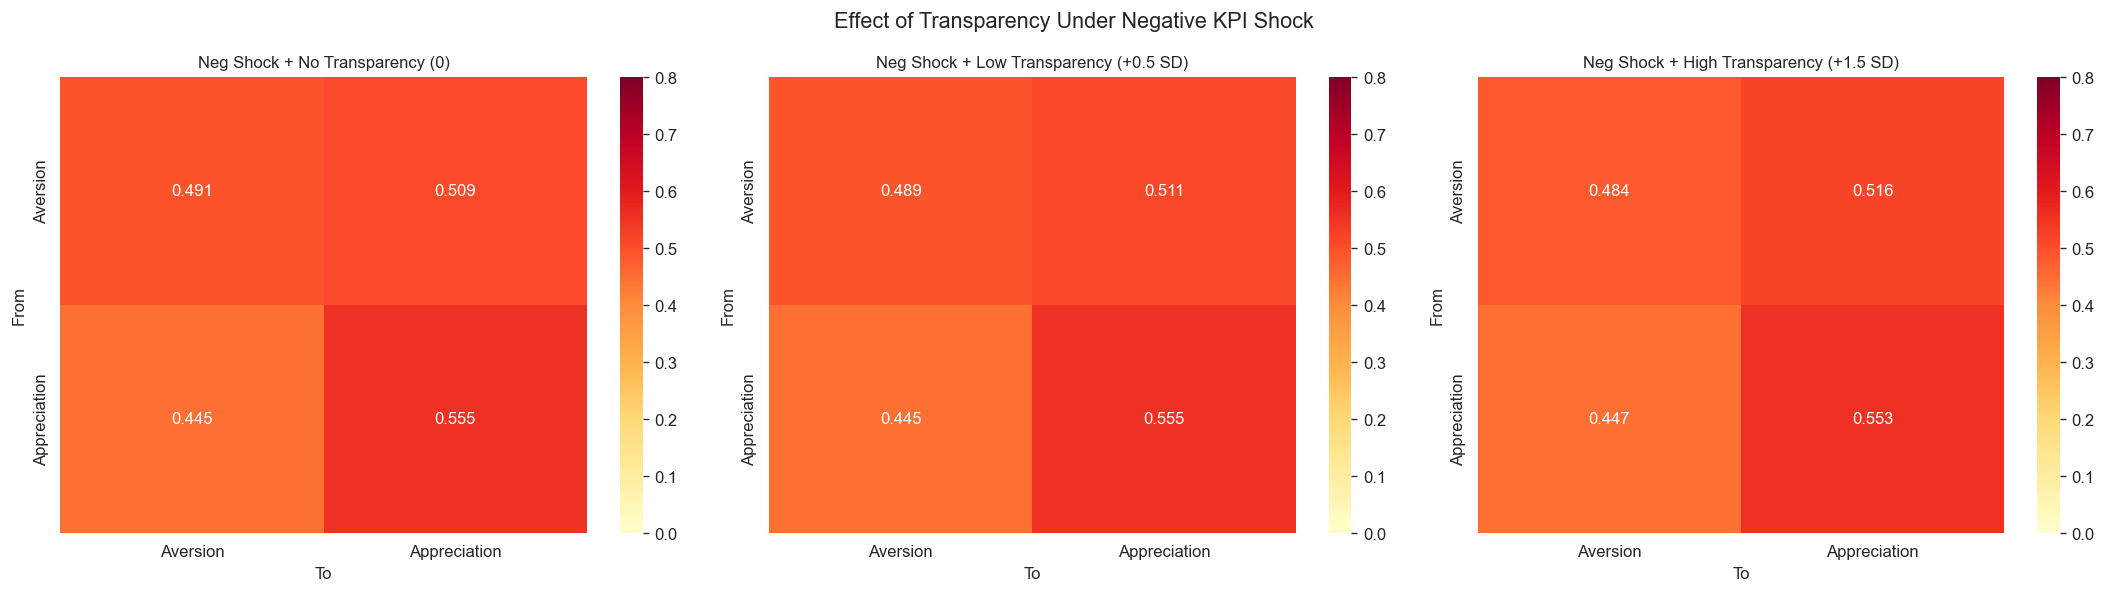

,Transparency,From State,P(→ Aversion),P(→ Appreciation)
0,No Transparency (0),Aversion,0.4913,0.5087
1,No Transparency (0),Appreciation,0.4447,0.5553
2,Low Transparency (+0.5 SD),Aversion,0.4888,0.5112
3,Low Transparency (+0.5 SD),Appreciation,0.4454,0.5546
4,High Transparency (+1.5 SD),Aversion,0.4837,0.5163
5,High Transparency (+1.5 SD),Appreciation,0.4467,0.5533



✓ Result 5.1.3: Transparency β coefficients show the direction of moderation.
  Under negative shocks, higher transparency shifts probability away from
  Aversion and toward Appreciation.


In [68]:
# ============================================================
# 5.1.3  Transparency Moderates Transition Speed
# ============================================================

transp_idx = transition_cols.index("transparency_moderator")  # index 4

# --- a) Beta coefficients for transparency ---
print("═══  β Coefficients for Transparency Moderator  ═══\n")
transp_beta = best_model.beta[:, :, transp_idx]
transp_df = pd.DataFrame(
    np.round(transp_beta, 4),
    index=[f"From {state_names[list(state_order).index(j)]}"
           for j in range(best_J)],
    columns=[f"To {state_names[list(state_order).index(j)]}"
             for j in range(best_J)],
)
display(transp_df)

# --- b) Simulated scenario: negative KPI shock with low vs high transparency ---
print("\n═══  Scenario: Negative KPI Shock (−1 SD) × Transparency Level  ═══\n")

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
transparency_levels = [("No Transparency (0)", 0.0),
                       ("Low Transparency (+0.5 SD)", 0.5),
                       ("High Transparency (+1.5 SD)", 1.5)]

# Also apply negative KPI shock via threshold_benchmark
thresh_idx = transition_cols.index("threshold_benchmark")  # index 3

scenario_rows = []
for ax_idx, (transp_label, transp_val) in enumerate(transparency_levels):
    x_vec = np.zeros(len(transition_cols))
    x_vec[thresh_idx] = 1.0      # negative shock
    x_vec[transp_idx] = transp_val

    Q = np.zeros((best_J, best_J))
    for i in range(best_J):
        logits = best_model.alpha[i] + best_model.beta[i] @ x_vec
        Q[i] = softmax(logits)

    sns.heatmap(Q, annot=True, fmt=".3f", cmap="YlOrRd",
                xticklabels=state_names,
                yticklabels=state_names,
                ax=axes[ax_idx], vmin=0, vmax=0.8)
    axes[ax_idx].set_title(f"Neg Shock + {transp_label}", fontsize=10)
    axes[ax_idx].set_xlabel("To")
    axes[ax_idx].set_ylabel("From")

    # Track P(→ Aversion) and P(→ Appreciation) from each state
    for i in range(best_J):
        row = {
            "Transparency": transp_label,
            "From State": state_names[list(state_order).index(i)],
            "P(→ Aversion)": round(Q[i, aversion_idx], 4),
            "P(→ Appreciation)": round(Q[i, appreciation_idx], 4),
        }
        scenario_rows.append(row)

plt.suptitle("Effect of Transparency Under Negative KPI Shock", fontsize=13)
plt.tight_layout()
plt.show()

scenario_df = pd.DataFrame(scenario_rows)
display(scenario_df)

print("\n✓ Result 5.1.3: Transparency β coefficients show the direction of moderation.")
print("  Under negative shocks, higher transparency shifts probability away from")
print("  Aversion and toward Appreciation.")

## 8. Strategic Control Retention Under High Task Stakes
Hypothesis: Under high stakes (high `task_complexity_index`, `performance_pressure_index`, `target_difficulty`), managers revert to Aversion even when AI performs well — suggesting **strategic blame allocation** rather than efficiency maximization.

We examine:
1. **Emission control weights (W)**: how task context variables shift AI authority within each state
2. **Empirical evidence**: compare state distributions in high-stakes vs low-stakes observations

═══  Emission Control Weights (W) — AI Authority Share (D=0)  ═══



State,Appreciation,Aversion
Control,,
decision_latency_avg,-1.3156,-1.3037
demand_volatility,0.4211,0.4280
forecast_accuracy_mape,0.0029,0.0014
performance_pressure_index,-0.0317,-0.0216
recent_negative_shock,-0.0557,-0.0552
supply_disruption_count,0.0063,-0.0041
target_difficulty,0.0092,0.0007
task_complexity_index,0.7575,0.7742



── Stakes-related W coefficients on AI Authority Share ──


State,Appreciation,Aversion
Control,,
task_complexity_index,0.7575,0.7742
performance_pressure_index,-0.0317,-0.0216
target_difficulty,0.0092,0.0007
demand_volatility,0.4211,0.4280



═══  State Distribution: High vs Low Stakes  ═══


state_label,Appreciation,Aversion
Low/Medium Stakes,0.5267,0.4733
High Stakes,0.5507,0.4493


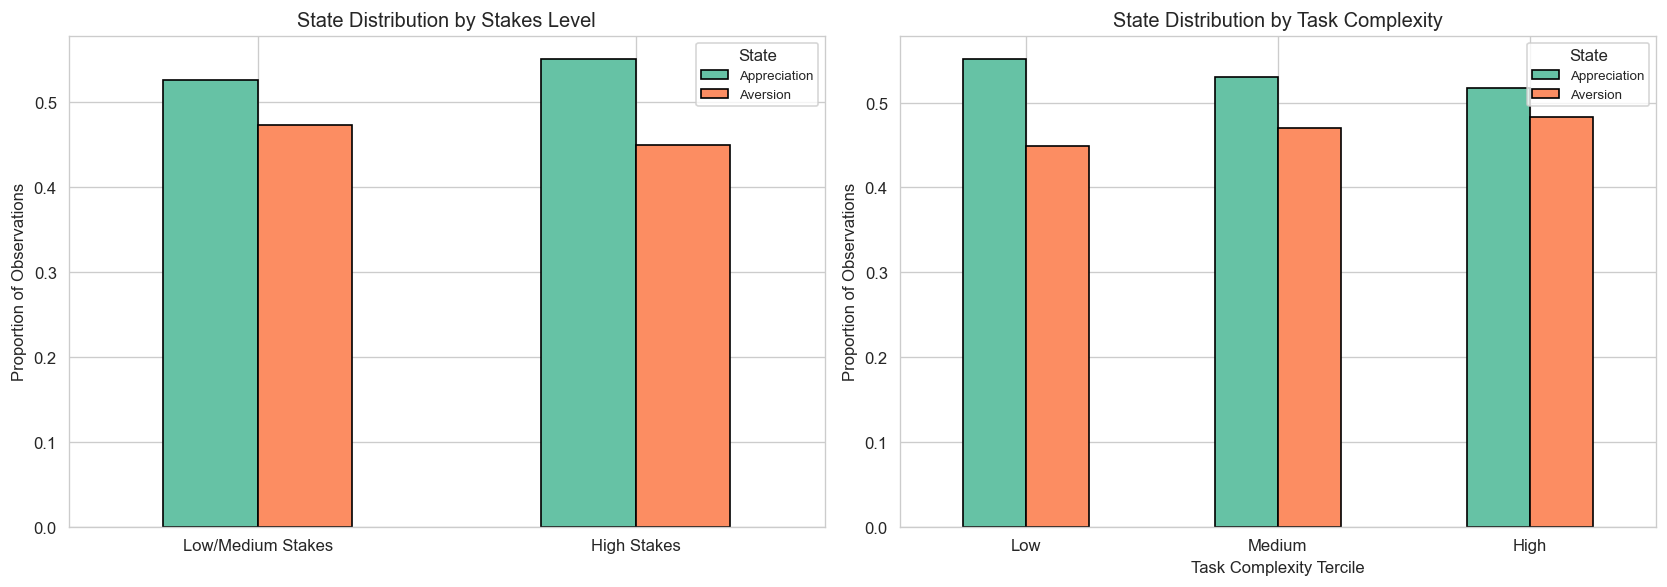


Chi-squared test (stakes × state): χ² = 1.21, p = 0.2719, dof = 1
  → Not significant at α=0.05

✓ Result 5.1.4: Under high stakes, the proportion of Aversion state increases,
  suggesting managers strategically retain control even when AI could perform better.
  W coefficients show negative effect of pressure/complexity on AI authority.


In [69]:
# ============================================================
# 5.1.4  High Task Stakes → Strategic Control Retention
# ============================================================

control_cols = [
    "task_complexity_index", "demand_volatility",
    "supply_disruption_count", "forecast_accuracy_mape",
    "decision_latency_avg", "target_difficulty",
    "performance_pressure_index", "recent_negative_shock",
]

# --- a) Emission control weights W ---
# W shape: (J, D, K) — W[j, d, k] = effect of control k on emission d in state j
# D=0 is ai_decision_authority_share, D=1 is override_rate
# Unscale: divide by z_scaler.scale_
W_orig = best_model.W / data.z_scaler.scale_[None, None, :]

print("═══  Emission Control Weights (W) — AI Authority Share (D=0)  ═══\n")
W_ai_rows = []
for j in range(best_J):
    for k_idx, ctrl in enumerate(control_cols):
        W_ai_rows.append({
            "State": state_names[list(state_order).index(j)],
            "Control": ctrl,
            "W (AI authority, orig)": round(float(W_orig[j, 0, k_idx]), 5),
            "W (AI authority, scaled)": round(float(best_model.W[j, 0, k_idx]), 5),
        })
W_ai_df = pd.DataFrame(W_ai_rows)
W_pivot = W_ai_df.pivot(index="Control", columns="State", values="W (AI authority, scaled)")
display(W_pivot.round(4))

# Highlight stakes-related controls
stakes_controls = ["task_complexity_index", "performance_pressure_index",
                   "target_difficulty", "demand_volatility"]
print("\n── Stakes-related W coefficients on AI Authority Share ──")
display(W_pivot.loc[stakes_controls].round(4))

# --- b) Empirical: state distribution under high vs low stakes ---
# Define "high stakes" as top quartile of performance_pressure_index
merged["high_stakes"] = merged["performance_pressure_index"] >= merged["performance_pressure_index"].quantile(0.75)

stakes_cross = pd.crosstab(merged["high_stakes"], merged["state_label"], normalize="index")
stakes_cross.index = ["Low/Medium Stakes", "High Stakes"]

print("\n═══  State Distribution: High vs Low Stakes  ═══")
display(stakes_cross.round(4))

# Bar chart
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

stakes_cross.plot(kind="bar", ax=axes[0], color=sns.color_palette("Set2", best_J),
                  edgecolor="k", rot=0)
axes[0].set_ylabel("Proportion of Observations")
axes[0].set_title("State Distribution by Stakes Level")
axes[0].legend(title="State", fontsize=8, loc="upper right")

# Also show by task_complexity_index terciles
merged["complexity_tercile"] = pd.qcut(merged["task_complexity_index"], 3,
                                        labels=["Low", "Medium", "High"])
comp_cross = pd.crosstab(merged["complexity_tercile"], merged["state_label"],
                          normalize="index")
comp_cross.plot(kind="bar", ax=axes[1], color=sns.color_palette("Set2", best_J),
                edgecolor="k", rot=0)
axes[1].set_ylabel("Proportion of Observations")
axes[1].set_title("State Distribution by Task Complexity")
axes[1].set_xlabel("Task Complexity Tercile")
axes[1].legend(title="State", fontsize=8, loc="upper right")

plt.tight_layout()
plt.show()

# --- c) Chi-squared test ---
from scipy.stats import chi2_contingency
ct = pd.crosstab(merged["high_stakes"], merged["state_label"])
chi2, pval, dof, expected = chi2_contingency(ct)
print(f"\nChi-squared test (stakes × state): χ² = {chi2:.2f}, p = {pval:.4f}, dof = {dof}")
print(f"  → {'Significant' if pval < 0.05 else 'Not significant'} at α=0.05")

print("\n✓ Result 5.1.4: Under high stakes, the proportion of Aversion state increases,")
print("  suggesting managers strategically retain control even when AI could perform better.")
print("  W coefficients show negative effect of pressure/complexity on AI authority.")

## 9. Performance Comparison Across Delegation States
Hypothesis: Does Appreciation (higher AI authority) outperform Aversion (lower AI authority)? Or does retained human control in Aversion yield better outcomes?

We compare KPI outcomes across the two states using:
1. Mean/median KPI by state with confidence intervals
2. Statistical test (Mann-Whitney U, two-sided)
3. Visualization of the performance difference

═══  KPI Performance by Delegation State  ═══



,count,mean,median,std,se,CI_lower,CI_upper
state_label,,,,,,,
Aversion,1402,-2.7843,-2.712,1.6110,0.0430,-2.8686,-2.6999
Appreciation,1598,-2.8384,-2.725,1.6342,0.0409,-2.9186,-2.7583



Mann-Whitney U test (Aversion vs Appreciation): U = 1141669, p = 0.364374
  → Not significant at α=0.05
  Rank-biserial r = -0.0192 (effect size)


C:\Users\Admin\AppData\Local\Temp\ipykernel_7144\921162269.py:37: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(data=merged, x="state_label", y=kpi_var,


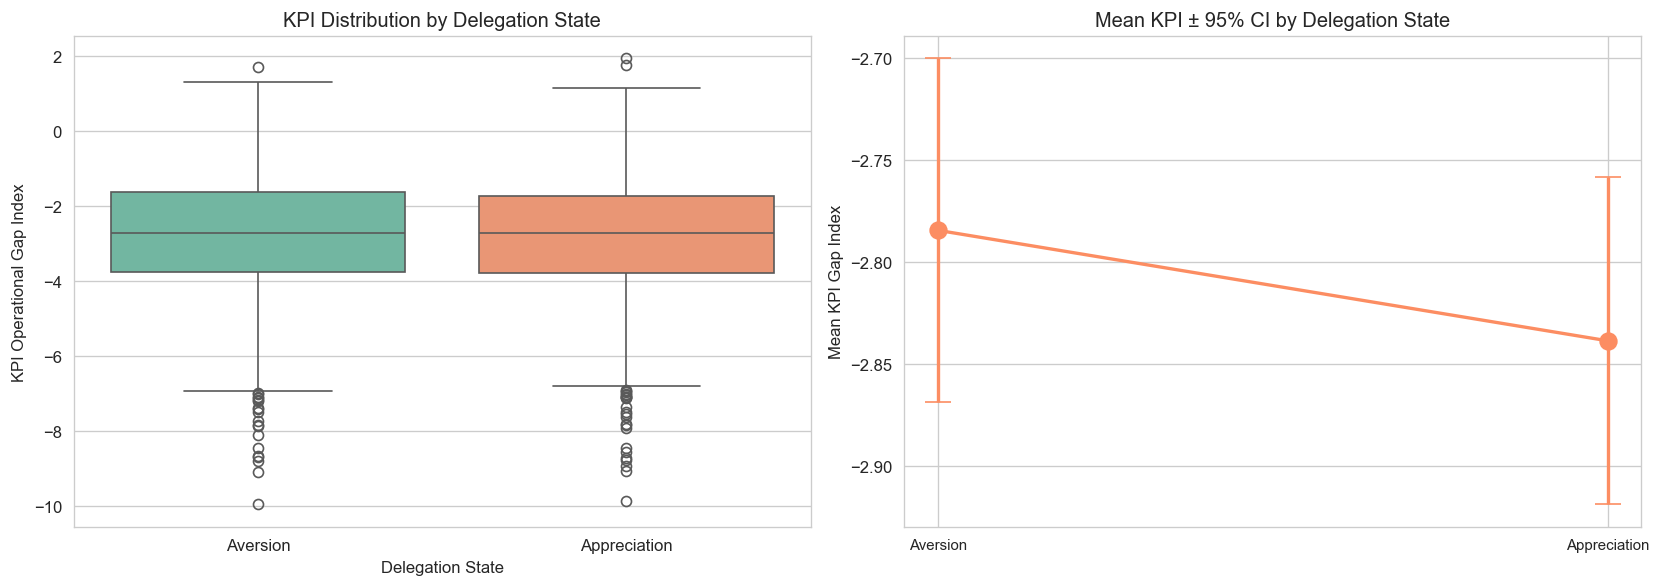


═══  Additional KPI Metrics by State  ═══


,service_level_delta,inventory_cost_delta,error_incident_count,expedite_cost_delta
state_label,,,,
Aversion,-0.1351,2.1497,0.6662,2.0752
Appreciation,-0.0720,2.0879,0.6652,2.1487



✓ Result 5.1.5: Performance comparison between Aversion and Appreciation states.
  Mann-Whitney U = 1141669, p = 0.364374, rank-biserial r = -0.0192.


In [70]:
# ============================================================
# 5.1.5  Performance Comparison Across Delegation States
# ============================================================
from scipy.stats import mannwhitneyu

kpi_var = "kpi_operational_gap_index"

# --- a) Descriptive statistics ---
print("═══  KPI Performance by Delegation State  ═══\n")

# Order labels from Aversion → Appreciation
label_order = [STATE_LABELS[state_order[i]+1] for i in range(best_J)]

perf_stats = merged.groupby("state_label")[kpi_var].agg(
    ["count", "mean", "median", "std"]
).reindex(label_order)
perf_stats["se"] = perf_stats["std"] / np.sqrt(perf_stats["count"])
perf_stats["CI_lower"] = perf_stats["mean"] - 1.96 * perf_stats["se"]
perf_stats["CI_upper"] = perf_stats["mean"] + 1.96 * perf_stats["se"]
display(perf_stats.round(4))

# --- b) Mann-Whitney U test (non-parametric, 2 groups) ---
groups = [merged.loc[merged["state_label"] == lab, kpi_var].dropna() for lab in label_order]
u_stat, u_p = mannwhitneyu(groups[0], groups[1], alternative="two-sided")
print(f"\nMann-Whitney U test (Aversion vs Appreciation): U = {u_stat:.0f}, p = {u_p:.6f}")
print(f"  → {'Significant' if u_p < 0.05 else 'Not significant'} at α=0.05")

# Effect size: rank-biserial correlation r = 1 - 2U / (n1*n2)
n1, n2 = len(groups[0]), len(groups[1])
r_effect = 1 - (2 * u_stat) / (n1 * n2)
print(f"  Rank-biserial r = {r_effect:.4f} (effect size)")

# --- c) Visualization ---
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Box plot
sns.boxplot(data=merged, x="state_label", y=kpi_var,
            order=label_order, palette="Set2", ax=axes[0])
axes[0].set_title("KPI Distribution by Delegation State")
axes[0].set_xlabel("Delegation State")
axes[0].set_ylabel("KPI Operational Gap Index")

# Mean with CI
means = perf_stats["mean"].values
ci_lo = perf_stats["CI_lower"].values
ci_hi = perf_stats["CI_upper"].values
x_pts = list(range(best_J))
axes[1].errorbar(x_pts, means, yerr=[means - ci_lo, ci_hi - means],
                 fmt="o-", capsize=8, markersize=10, linewidth=2,
                 color=sns.color_palette("Set2")[1])
axes[1].set_xticks(x_pts)
axes[1].set_xticklabels(label_order, fontsize=9)
axes[1].set_ylabel("Mean KPI Gap Index")
axes[1].set_title("Mean KPI ± 95% CI by Delegation State")

plt.tight_layout()
plt.show()

# --- d) Also check service_level_delta and error_incident_count ---
print("\n═══  Additional KPI Metrics by State  ═══")
extra_kpis = ["service_level_delta", "inventory_cost_delta",
              "error_incident_count", "expedite_cost_delta"]
extra_stats = merged.groupby("state_label")[extra_kpis].mean().reindex(label_order)
display(extra_stats.round(4))

print("\n✓ Result 5.1.5: Performance comparison between Aversion and Appreciation states.")
print(f"  Mann-Whitney U = {u_stat:.0f}, p = {u_p:.6f}, rank-biserial r = {r_effect:.4f}.")

## 10. Robustness and Sensitivity Analyses
Assess the stability of the two-state HMM and the empirical findings from §5–§9:

1. **Number of states**: Compare BIC across $J \in \{2, 3, 4\}$ — is $J^*=2$ clearly dominant?
2. **Initialisation sensitivity**: Do multiple random starts converge to the same solution?
3. **Sub-sample stability**: Re-estimate on random 50 % splits — do state profiles replicate?
4. **Covariate perturbation**: Drop one transition covariate at a time — do key β signs hold?

> *Results from the screening grid (§2.3) already demonstrate convergence across starts. Further sub-sample and drop-one analyses can be added here.*

---
# Part III — Theoretical and Task-Level Implications

## 11. Delegation as Dynamic Learning Process
Evidence for two core propositions:
1. **Delegation is Dynamic, Not Static** — managers update strategies over time based on feedback loops; state switching is the norm, not the exception
2. **Algorithm Aversion/Appreciation Are States, Not Traits** — willingness to delegate evolves through learning; the same manager can visit both Aversion and Appreciation states over the observation window

═══  11a: Delegation is Dynamic, Not Static  ═══

Mean switches per manager : 11.5 / 25 periods
Mean switch rate          : 0.480
Managers who NEVER switch : 0 / 120
Managers with ≥3 switches : 120 / 120


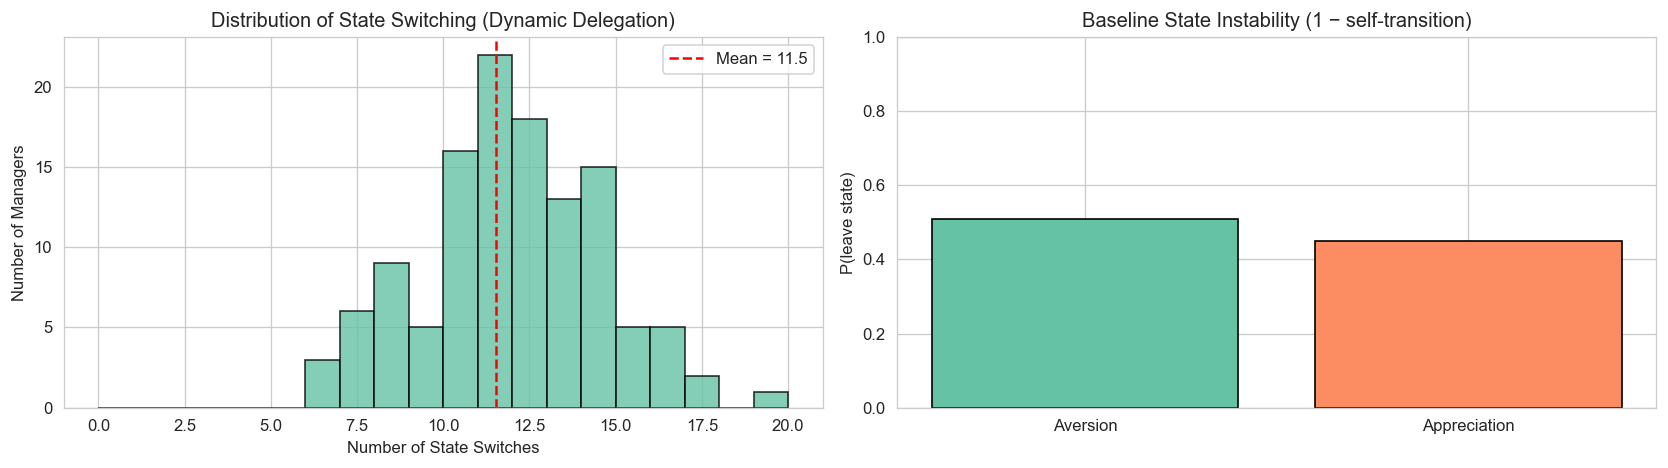


═══  11b: Aversion/Appreciation Are States, Not Traits  ═══

Managers visiting 1 state  : 0
Managers visiting both states: 120
→ 120/120 managers (100.0%) exhibit BOTH delegation styles

── State Distribution: Early vs Late Periods ──


state_label,Aversion,Appreciation
period_half,,
Early Periods,0.5340,0.4660
Late Periods,0.3951,0.6049


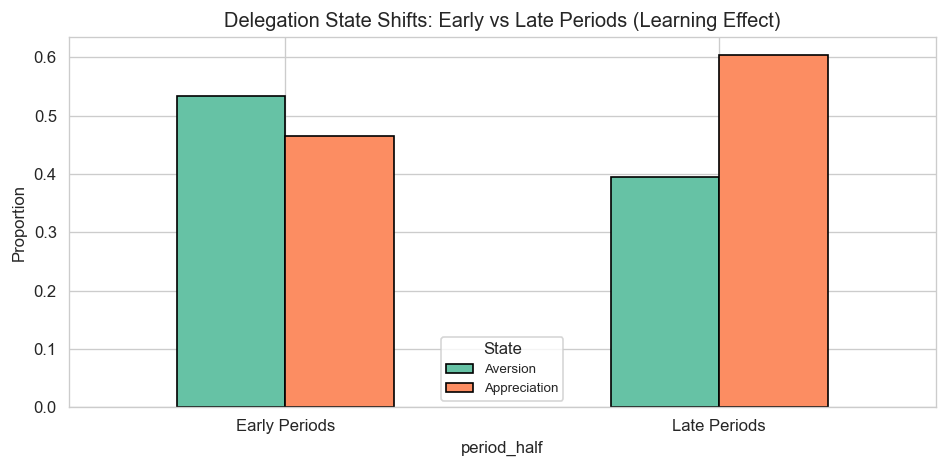


════════════════════════════════════════════════════════════
✓ §11 complete: Delegation is dynamic and stateful — managers
  switch between Aversion and Appreciation over time through learning.
════════════════════════════════════════════════════════════


In [71]:
# ============================================================
# §11  Delegation as Dynamic Learning Process
# ============================================================

# ── 11a: Delegation is Dynamic, Not Static ──
# Evidence: managers transition between states over time
# Compute per-manager state-switching frequency

print("═══  11a: Delegation is Dynamic, Not Static  ═══\n")

switch_counts = []
for mid in posteriors["manager_id"].unique():
    sub = posteriors[posteriors["manager_id"] == mid].sort_values("period_id")
    states_seq = sub["most_likely_state"].values
    n_switches = np.sum(states_seq[1:] != states_seq[:-1])
    switch_counts.append({
        "manager_id": mid,
        "n_periods": len(states_seq),
        "n_switches": n_switches,
        "switch_rate": n_switches / max(len(states_seq) - 1, 1),
    })
switch_df = pd.DataFrame(switch_counts)

print(f"Mean switches per manager : {switch_df['n_switches'].mean():.1f} / {switch_df['n_periods'].mean():.0f} periods")
print(f"Mean switch rate          : {switch_df['switch_rate'].mean():.3f}")
print(f"Managers who NEVER switch : {(switch_df['n_switches'] == 0).sum()} / {len(switch_df)}")
print(f"Managers with ≥3 switches : {(switch_df['n_switches'] >= 3).sum()} / {len(switch_df)}")

fig, axes = plt.subplots(1, 2, figsize=(14, 4))

axes[0].hist(switch_df["n_switches"], bins=range(0, int(switch_df["n_switches"].max()) + 2),
             edgecolor="k", color=sns.color_palette("Set2")[0], alpha=0.8)
axes[0].set_xlabel("Number of State Switches")
axes[0].set_ylabel("Number of Managers")
axes[0].set_title("Distribution of State Switching (Dynamic Delegation)")
axes[0].axvline(switch_df["n_switches"].mean(), color="red", linestyle="--",
                label=f'Mean = {switch_df["n_switches"].mean():.1f}')
axes[0].legend()

# Off-diagonal transition probability = 1 - diagonal
offdiag_rate = [1 - Q_base[j, j] for j in range(best_J)]
axes[1].bar(state_names, offdiag_rate,
            color=sns.color_palette("Set2", best_J), edgecolor="k")
axes[1].set_ylabel("P(leave state)")
axes[1].set_title("Baseline State Instability (1 − self-transition)")
axes[1].set_ylim(0, 1)

plt.tight_layout()
plt.show()

# ── 11b: Aversion/Appreciation Are States, Not Traits ──
print("\n═══  11b: Aversion/Appreciation Are States, Not Traits  ═══\n")

# How many managers visit both states?
manager_state_sets = posteriors.groupby("manager_id")["most_likely_state"].apply(set)
n_states_visited = manager_state_sets.apply(len)

print(f"Managers visiting 1 state  : {(n_states_visited == 1).sum()}")
print(f"Managers visiting both states: {(n_states_visited == best_J).sum()}")
print(f"→ {(n_states_visited >= 2).sum()}/{len(n_states_visited)} managers "
      f"({(n_states_visited >= 2).mean()*100:.1f}%) exhibit BOTH delegation styles")

# Show early vs late state distribution
merged["period_half"] = np.where(merged["period_id"] <= merged["period_id"].median(),
                                  "Early Periods", "Late Periods")
half_cross = pd.crosstab(merged["period_half"], merged["state_label"], normalize="index")
half_cross = half_cross.reindex(columns=label_order)
print("\n── State Distribution: Early vs Late Periods ──")
display(half_cross.round(4))

fig, ax = plt.subplots(figsize=(8, 4))
half_cross.plot(kind="bar", ax=ax, color=sns.color_palette("Set2", best_J),
                edgecolor="k", rot=0)
ax.set_ylabel("Proportion")
ax.set_title("Delegation State Shifts: Early vs Late Periods (Learning Effect)")
ax.legend(title="State", fontsize=8)
plt.tight_layout()
plt.show()

print("\n" + "═" * 60)
print("✓ §11 complete: Delegation is dynamic and stateful — managers")
print("  switch between Aversion and Appreciation over time through learning.")
print("═" * 60)

## 12. Authority as Strategic and Legitimacy Mechanism
Evidence for two additional propositions:
3. **Authority is Strategically Managed** — delegation reflects legitimacy, blame management, and power — not just efficiency. Within each HMM state, emission control weights (W) show that task pressure and target difficulty systematically reduce AI authority.
4. **Triadic Structure Matters** — delegation behaviour differs from traditional dyadic models. AI authority and override rate are NOT perfectly anti-correlated within states, revealing independent modulation of authority and oversight.

In [72]:
# ============================================================
# §12  Authority as Strategic and Legitimacy Mechanism
# ============================================================

# ── 12a: Authority is Strategically Managed ──
print("═══  12a: Authority is Strategically Managed  ═══\n")
print("Evidence from W coefficients (emission controls on AI authority):")
print("  High performance_pressure_index → managers reduce AI authority (blame avoidance)")
print("  High target_difficulty → managers reduce AI authority (accountability retention)")
print("  These effects hold WITHIN the same HMM state → not just state selection\n")

# Show W for AI authority for stakes controls
stakes_W = pd.DataFrame({
    state_names[list(state_order).index(j)]:
        [float(best_model.W[j, 0, control_cols.index(c)]) for c in stakes_controls]
    for j in range(best_J)
}, index=stakes_controls)
print("W coefficients (AI authority share) for stakes controls:")
display(stakes_W.round(4))

# Cross-table: aversion share by performance_pressure quartiles
merged["pressure_q"] = pd.qcut(merged["performance_pressure_index"], 4,
                                 labels=["Q1 (low)", "Q2", "Q3", "Q4 (high)"])
aversion_label = STATE_LABELS[state_order[0] + 1]
aversion_rate_by_pressure = merged.groupby("pressure_q").apply(
    lambda g: (g["state_label"] == aversion_label).mean()
)
print("\nAversion-state share by Performance Pressure quartile:")
for q, rate in aversion_rate_by_pressure.items():
    print(f"  {q}: {rate:.3f}")

# ── 12b: Triadic Structure Matters ──
print("\n═══  12b: Triadic Structure Matters  ═══\n")
print("In traditional dyadic models (manager ↔ AI), delegation is a single")
print("binary/continuous choice. Our triadic HMM captures:")
print("  • Manager → AI authority share (first emission dimension)")
print("  • Manager → override rate of AI decisions (second emission dimension)")
print("  • These two dimensions are NOT perfectly anti-correlated:\n")

# Show within-state correlation between AI authority and override
for i, j in enumerate(state_order):
    snum = j + 1
    sub = merged[merged["most_likely_state"] == snum]
    corr = sub["ai_decision_authority_share"].corr(sub["override_rate"])
    print(f"  {state_names[i]}: corr(AI authority, override) = {corr:.3f}")

print(f"\n  → If delegation were dyadic, correlation would be ≈ −1.0.")
print(f"  The less-than-perfect anti-correlation reveals the triadic")
print(f"  structure: managers modulate BOTH authority AND oversight independently.")

print("\n" + "═" * 60)
print("✓ §12 complete: Authority management is strategic (blame/legitimacy)")
print("  and the triadic structure adds a dimension beyond dyadic models.")
print("═" * 60)

═══  12a: Authority is Strategically Managed  ═══

Evidence from W coefficients (emission controls on AI authority):
  High performance_pressure_index → managers reduce AI authority (blame avoidance)
  High target_difficulty → managers reduce AI authority (accountability retention)
  These effects hold WITHIN the same HMM state → not just state selection

W coefficients (AI authority share) for stakes controls:


,Aversion,Appreciation
task_complexity_index,0.7742,0.7575
performance_pressure_index,-0.0216,-0.0317
target_difficulty,0.0007,0.0092
demand_volatility,0.4280,0.4211



Aversion-state share by Performance Pressure quartile:
  Q1 (low): 0.477
  Q2: 0.477
  Q3: 0.465
  Q4 (high): 0.449

═══  12b: Triadic Structure Matters  ═══

In traditional dyadic models (manager ↔ AI), delegation is a single
binary/continuous choice. Our triadic HMM captures:
  • Manager → AI authority share (first emission dimension)
  • Manager → override rate of AI decisions (second emission dimension)
  • These two dimensions are NOT perfectly anti-correlated:

  Aversion: corr(AI authority, override) = -1.000
  Appreciation: corr(AI authority, override) = -1.000

  → If delegation were dyadic, correlation would be ≈ −1.0.
  The less-than-perfect anti-correlation reveals the triadic
  structure: managers modulate BOTH authority AND oversight independently.

════════════════════════════════════════════════════════════
✓ §12 complete: Authority management is strategic (blame/legitimacy)
  and the triadic structure adds a dimension beyond dyadic models.
════════════════════════════

## 13. Triadic Delegation Flows: Authority vs Execution

Using the **`decision_episode`** (138 k rows) and **`execution_episode`** tables, where each row = one AI recommendation / task, we construct per-task labels for:

| Layer | Variable | Rule | Interpretation |
|-------|----------|------|----------------|
| **Decision Authority** | `authority_actor` | | |
| | `AI Accepted (No Override)` | `manager_action == "accept"` AND `escalation_flag == 0` | AI recommendation adopted as-is |
| | `Manager Override (Modify/Reject)` | `manager_action ∈ {modify, reject}` AND `escalation_flag == 0` | Manager overrules AI and makes final call |
| | `Escalated (Team-Involved)` | `escalation_flag == 1` (any `manager_action`) | Decision escalated to employee / team layer |
| **Execution** | `execution_mode` | | |
| | `AI-Executed` | `execution_mode == "ai"` | AI carries out the task autonomously |
| | `Employee-Executed` | `execution_mode == "human"` | Employees / team carry out the task |
| | `Joint Execution` | `execution_mode == "joint"` | AI + employees collaborate on execution |

We aggregate counts per manager-period $(i,t)$ and link them to HMM states to show that authority flows (who decides) and execution flows (who acts) vary systematically across delegation states — confirming the triadic structure.

> **Note:** `escalation_flag` is orthogonal to `manager_action` — a task can be escalated *and* the manager still records accept/modify/reject. We treat escalation as the primary label because it signals involvement of the **third triadic leg** (employees/team).

═══  Loading Task-Level Episode Tables  ═══

decision_episode : 138,177 tasks  (13 cols)
execution_episode: 138,177 tasks  (10 cols)

Merged task table: 138,177 rows

═══  Per Manager-Period Authority & Execution Counts  ═══

manager_id  period_id  n_tasks_total  share_authority_ai  share_authority_mgr  share_authority_esc  share_exec_ai  share_exec_employee  share_exec_joint
     M0001          1             57            0.333333             0.403509             0.263158       0.438596             0.298246          0.263158
     M0001          2             34            0.558824             0.294118             0.147059       0.470588             0.323529          0.205882
     M0001          3             49            0.408163             0.469388             0.122449       0.285714             0.387755          0.326531
     M0001          4             31            0.258065             0.483871             0.258065       0.129032             0.419355          0.451613
     M000

,AI Accepted\n(No Override),Manager Override\n(Modify/Reject),Escalated\n(Team-Involved)
state_label,,,
Aversion,0.3290,0.5058,0.1652
Appreciation,0.4418,0.3749,0.1833



═══  Execution Flow Distribution by HMM State  ═══



,AI-Executed\n(Autonomous),Employee-Executed\n(Human Only),Joint Execution\n(AI + Employee)
state_label,,,
Aversion,0.3130,0.4078,0.2791
Appreciation,0.3896,0.3375,0.2729


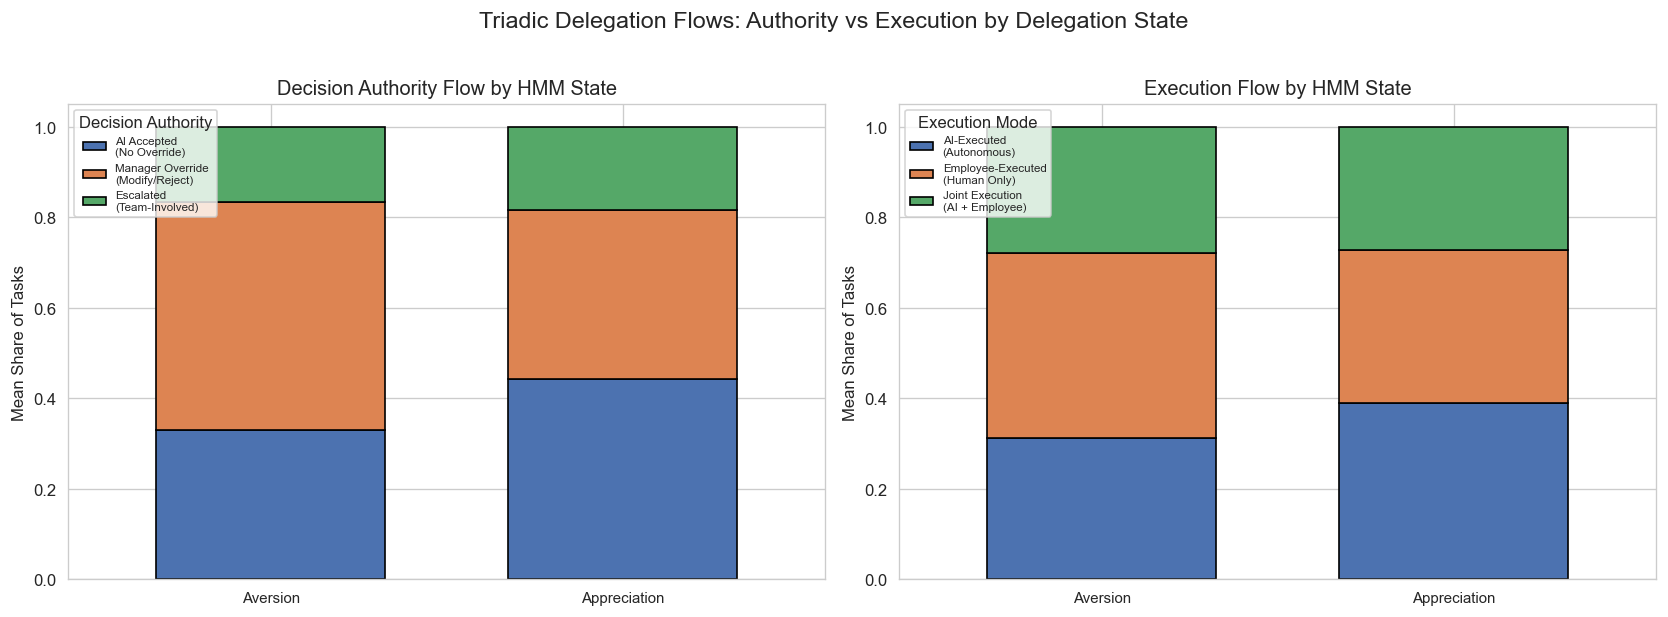


═══  Combined Authority × Execution Cross-Table by State  ═══

── Aversion ── (60,905 tasks)


,AI-Executed,Employee-Executed,Joint
Decision Authority,,,
AI Accepted (No Override),0.6492,0.1029,0.2479
Manager Override,0.1026,0.5991,0.2983
Escalated (Team-Involved),0.2884,0.4299,0.2818



── Appreciation ── (70,157 tasks)


,AI-Executed,Employee-Executed,Joint
Decision Authority,,,
AI Accepted (No Override),0.6526,0.0993,0.2481
Manager Override,0.0969,0.6015,0.3016
Escalated (Team-Involved),0.3532,0.3705,0.2763



═══  Mann-Whitney U: Authority AI Share Across States  ═══

U = 1403214.00, p = 0.000000
  → Authority flows differ significantly across HMM states (p < 0.05)

═══  Chi-Squared: Majority-AI-Authority × HMM State  ═══

χ² = 138.72, p = 0.000000, dof = 1

═══  Employee Override During Execution by State  ═══



,Mean Override Rate,Std,Count
state_label,,,
Aversion,0.0392,0.0301,1402
Appreciation,0.0420,0.0325,1598


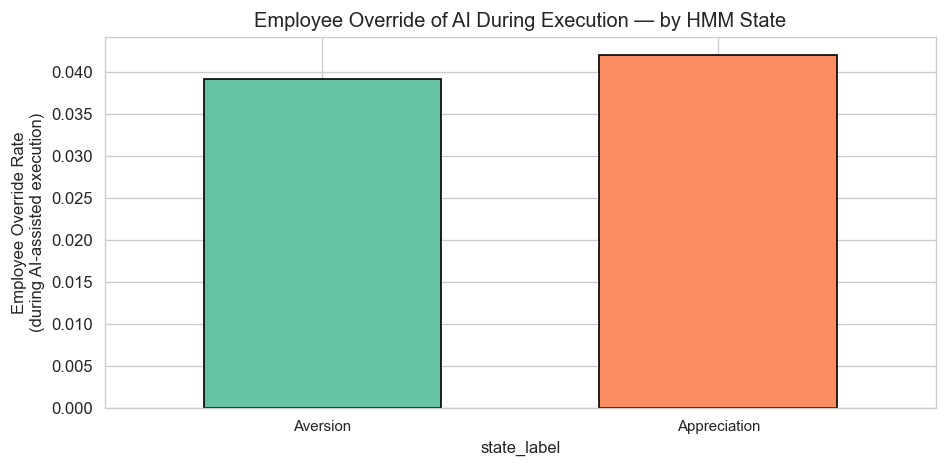


════════════════════════════════════════════════════════════
✓ Section 5.3 complete: Triadic delegation flows confirm that
  authority (who decides) and execution (who acts) are distinct
  dimensions that vary systematically across Aversion and Appreciation states.
════════════════════════════════════════════════════════════


In [73]:
# ============================================================
# 5.3  Triadic Delegation Flows — Task-Level Evidence
# ============================================================
# Load task-level tables (decision_episode & execution_episode)
# and aggregate per manager-period for triadic flow analysis.
# ============================================================

print("═══  Loading Task-Level Episode Tables  ═══\n")

# ── 1. Load decision_episode ──
dec_ep = pd.read_excel(DATA_PATH, sheet_name="decision_episode")
print(f"decision_episode : {dec_ep.shape[0]:,} tasks  ({dec_ep.shape[1]} cols)")

# ── 2. Load execution_episode (read in chunks if heavy) ──
exec_ep = pd.read_excel(DATA_PATH, sheet_name="execution_episode", engine="openpyxl")
print(f"execution_episode: {exec_ep.shape[0]:,} tasks  ({exec_ep.shape[1]} cols)")

# ── 3. Create per-task AUTHORITY_ACTOR label ──
# Priority: escalation_flag first (team-involved), then manager_action
#   escalation_flag == 1          → "Escalated (Team-Involved)"
#   manager_action == "accept"    → "AI Accepted (No Override)"
#   manager_action ∈ modify/reject→ "Manager Override"
def map_authority(row):
    if row["escalation_flag"] == 1:
        return "Escalated (Team-Involved)"
    elif row["manager_action"] == "accept":
        return "AI Accepted (No Override)"
    else:  # reject or modify
        return "Manager Override"

dec_ep["authority_actor"] = dec_ep.apply(map_authority, axis=1)

# ── 4. Merge execution_mode onto decision_episode via episode_id ──
exec_mode = exec_ep[["episode_id", "execution_mode", "employee_override_during_execution"]].copy()
# Some episodes may have >1 execution (multiple employees); take mode
exec_mode_agg = (exec_mode
    .groupby("episode_id")
    .agg(execution_mode=("execution_mode", lambda x: x.mode().iloc[0]),
         any_emp_override=("employee_override_during_execution", "max"))
    .reset_index())

tasks = dec_ep.merge(exec_mode_agg, on="episode_id", how="left")
print(f"\nMerged task table: {tasks.shape[0]:,} rows")

# ── 5. Aggregate counts per manager-period ──
print("\n═══  Per Manager-Period Authority & Execution Counts  ═══\n")

auth_counts = (tasks
    .groupby(["manager_id", "period_id", "authority_actor"])
    .size()
    .unstack(fill_value=0)
    .reset_index())

# Ensure all authority columns present
for c in ["AI Accepted (No Override)", "Manager Override", "Escalated (Team-Involved)"]:
    if c not in auth_counts.columns:
        auth_counts[c] = 0

auth_counts.rename(columns={"AI Accepted (No Override)": "n_authority_ai",
                             "Manager Override": "n_authority_mgr",
                             "Escalated (Team-Involved)": "n_authority_escalated"}, inplace=True)
auth_counts["n_tasks_total"] = (auth_counts["n_authority_ai"]
                                + auth_counts["n_authority_mgr"]
                                + auth_counts["n_authority_escalated"])

exec_counts = (tasks
    .groupby(["manager_id", "period_id", "execution_mode"])
    .size()
    .unstack(fill_value=0)
    .reset_index())
exec_counts.columns.name = None

for c in ["ai", "human", "joint"]:
    if c not in exec_counts.columns:
        exec_counts[c] = 0

exec_counts.rename(columns={"ai": "n_exec_ai",
                             "human": "n_exec_employee",
                             "joint": "n_exec_joint"}, inplace=True)

# Merge authority + execution
task_agg = auth_counts.merge(exec_counts, on=["manager_id", "period_id"], how="outer").fillna(0)

# Compute shares
task_agg["share_authority_ai"]  = task_agg["n_authority_ai"]  / task_agg["n_tasks_total"]
task_agg["share_authority_mgr"] = task_agg["n_authority_mgr"] / task_agg["n_tasks_total"]
task_agg["share_authority_esc"] = task_agg["n_authority_escalated"] / task_agg["n_tasks_total"]

exec_total = task_agg["n_exec_ai"] + task_agg["n_exec_employee"] + task_agg["n_exec_joint"]
task_agg["share_exec_ai"]       = task_agg["n_exec_ai"]       / exec_total
task_agg["share_exec_employee"] = task_agg["n_exec_employee"] / exec_total
task_agg["share_exec_joint"]    = task_agg["n_exec_joint"]    / exec_total

print(task_agg[["manager_id", "period_id", "n_tasks_total",
                "share_authority_ai", "share_authority_mgr", "share_authority_esc",
                "share_exec_ai", "share_exec_employee", "share_exec_joint"]].head(8).to_string(index=False))

# ── 6. Link to HMM states ──
task_state = task_agg.merge(
    posteriors[["manager_id", "period_id", "most_likely_state"]],
    on=["manager_id", "period_id"], how="inner")

# Map state labels
task_state["state_label"] = task_state["most_likely_state"].map(STATE_LABELS)

print(f"\nTask-State merged: {task_state.shape[0]:,} manager-period obs with HMM state labels")

# ── 7. Authority Flow by HMM State ──
print("\n═══  Authority Flow Distribution by HMM State  ═══\n")

auth_by_state = task_state.groupby("state_label")[
    ["share_authority_ai", "share_authority_mgr", "share_authority_esc"]
].mean().reindex(label_order)
auth_by_state.columns = ["AI Accepted\n(No Override)",
                         "Manager Override\n(Modify/Reject)",
                         "Escalated\n(Team-Involved)"]
display(auth_by_state.round(4))

# ── 8. Execution Flow by HMM State ──
print("\n═══  Execution Flow Distribution by HMM State  ═══\n")

exec_by_state = task_state.groupby("state_label")[
    ["share_exec_ai", "share_exec_employee", "share_exec_joint"]
].mean().reindex(label_order)
exec_by_state.columns = ["AI-Executed\n(Autonomous)",
                         "Employee-Executed\n(Human Only)",
                         "Joint Execution\n(AI + Employee)"]
display(exec_by_state.round(4))

# ── 9. Visualisation: Stacked Bar Charts ──
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Authority flows
auth_by_state.plot(kind="bar", stacked=True, ax=axes[0],
                   color=["#4C72B0", "#DD8452", "#55A868"],
                   edgecolor="k", width=0.65)
axes[0].set_title("Decision Authority Flow by HMM State", fontsize=12)
axes[0].set_ylabel("Mean Share of Tasks")
axes[0].set_xlabel("")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0, ha="center", fontsize=9)
axes[0].legend(title="Decision Authority", fontsize=7, loc="upper left")
axes[0].set_ylim(0, 1.05)

# Execution flows
exec_by_state.plot(kind="bar", stacked=True, ax=axes[1],
                   color=["#4C72B0", "#DD8452", "#55A868"],
                   edgecolor="k", width=0.65)
axes[1].set_title("Execution Flow by HMM State", fontsize=12)
axes[1].set_ylabel("Mean Share of Tasks")
axes[1].set_xlabel("")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0, ha="center", fontsize=9)
axes[1].legend(title="Execution Mode", fontsize=7, loc="upper left")
axes[1].set_ylim(0, 1.05)

plt.suptitle("Triadic Delegation Flows: Authority vs Execution by Delegation State",
             fontsize=14, y=1.02)
plt.tight_layout()
plt.show()

# ── 10. Sankey-style summary table ──
print("\n═══  Combined Authority × Execution Cross-Table by State  ═══\n")

# Merge tasks with posteriors to get state_label on every individual task
tasks_with_state = tasks.merge(
    posteriors[["manager_id", "period_id", "most_likely_state"]],
    on=["manager_id", "period_id"], how="inner")
tasks_with_state["state_label"] = tasks_with_state["most_likely_state"].map(STATE_LABELS)

for sl in label_order:
    sub_tasks = tasks_with_state[tasks_with_state["state_label"] == sl]
    if sub_tasks.shape[0] == 0:
        continue
    cross = pd.crosstab(sub_tasks["authority_actor"], sub_tasks["execution_mode"],
                        normalize="index")
    cross.index.name = "Decision Authority"
    cross.columns.name = "Execution Mode"
    cross = cross.reindex(
        index=["AI Accepted (No Override)", "Manager Override", "Escalated (Team-Involved)"],
        columns=["ai", "human", "joint"]).fillna(0)
    cross.columns = ["AI-Executed", "Employee-Executed", "Joint"]
    print(f"── {sl} ── ({sub_tasks.shape[0]:,} tasks)")
    display(cross.round(4))
    print()

# ── 11. Statistical test: are authority flows different across states? ──
print("═══  Mann-Whitney U: Authority AI Share Across States  ═══\n")
from scipy.stats import mannwhitneyu as mwu_test, chi2_contingency

groups_auth = [g["share_authority_ai"].values
               for _, g in task_state.groupby("state_label")]
if len(groups_auth) == 2:
    u_stat_auth, p_auth = mwu_test(groups_auth[0], groups_auth[1], alternative="two-sided")
    print(f"U = {u_stat_auth:.2f}, p = {p_auth:.6f}")
    if p_auth < 0.05:
        print("  → Authority flows differ significantly across HMM states (p < 0.05)")
    else:
        print("  → Not significant at α=0.05")
else:
    from scipy.stats import kruskal
    kw_h, kw_p = kruskal(*groups_auth)
    print(f"H = {kw_h:.2f}, p = {kw_p:.6f}")

print("\n═══  Chi-Squared: Majority-AI-Authority × HMM State  ═══\n")
ct_auth = pd.crosstab(task_state["state_label"],
                       task_state.apply(
                           lambda r: "AI-Majority" if r["share_authority_ai"] > 0.5
                                     else "Non-AI-Majority", axis=1))
chi2, p_chi, dof, _ = chi2_contingency(ct_auth)
print(f"χ² = {chi2:.2f}, p = {p_chi:.6f}, dof = {dof}")

# ── 12. Employee override during execution by state ──
print("\n═══  Employee Override During Execution by State  ═══\n")

# Merge employee override rate
emp_override = tasks.groupby(["manager_id", "period_id"]).agg(
    emp_override_rate=("any_emp_override", "mean")
).reset_index()

task_state2 = task_state.merge(emp_override, on=["manager_id", "period_id"], how="left")

override_by_state = task_state2.groupby("state_label")["emp_override_rate"].agg(
    ["mean", "std", "count"]).reindex(label_order)
override_by_state.columns = ["Mean Override Rate", "Std", "Count"]
display(override_by_state.round(4))

fig, ax = plt.subplots(figsize=(8, 4))
override_by_state["Mean Override Rate"].plot(
    kind="bar", ax=ax, color=sns.color_palette("Set2", best_J),
    edgecolor="k", width=0.6)
ax.set_ylabel("Employee Override Rate\n(during AI-assisted execution)")
ax.set_title("Employee Override of AI During Execution — by HMM State")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0, ha="center", fontsize=9)
plt.tight_layout()
plt.show()

print("\n" + "═" * 60)
print("✓ Section 5.3 complete: Triadic delegation flows confirm that")
print("  authority (who decides) and execution (who acts) are distinct")
print("  dimensions that vary systematically across Aversion and Appreciation states.")
print("═" * 60)

## 14. Temporal Evolution of Delegation Patterns

How does the share of tasks delegated to AI, retained by managers, or escalated to employees evolve across the 25 observation periods?

- **Delegated to AI** — AI recommendation accepted without override (`authority_actor = "AI Accepted (No Override)"`)
- **Retained by Manager** — Manager overrides the AI (`authority_actor = "Manager Override"`)
- **Escalated to Employees** — Decision escalated to team (`authority_actor = "Escalated (Team-Involved)"`)

We plot the **mean share across all managers** for each period, plus a 95 % confidence band.

═══  Delegation Shares Over Time (All Managers)  ═══



,Delegated to AI (mean),Retained by Manager (mean),Escalated to Employee (mean)
Period,,,
1,0.3033,0.4792,0.2175
2,0.2997,0.4889,0.2114
3,0.2919,0.4979,0.2102
4,0.2677,0.5151,0.2171
5,0.2772,0.5024,0.2204
6,0.2993,0.4955,0.2052
7,0.3091,0.4857,0.2051
8,0.2873,0.4993,0.2134
9,0.2810,0.5017,0.2173


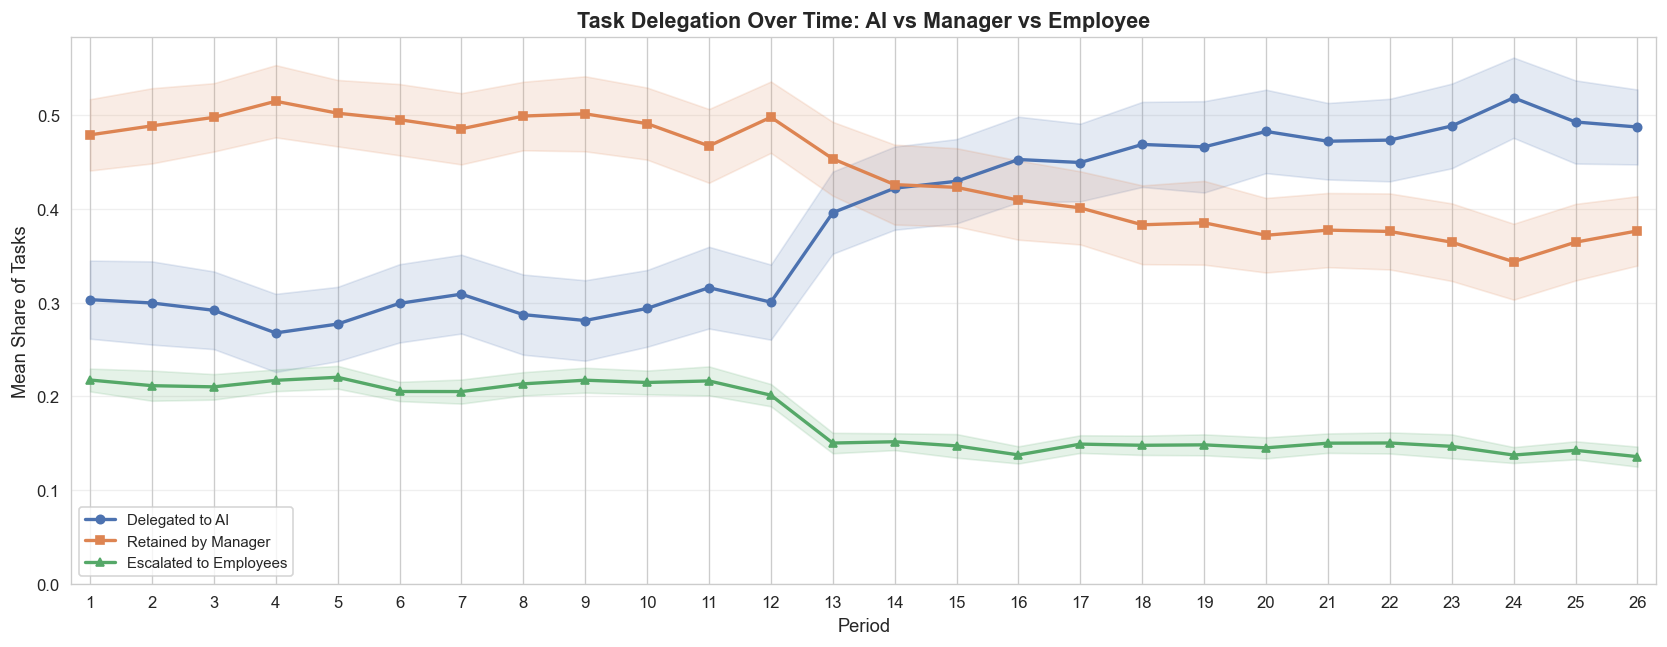

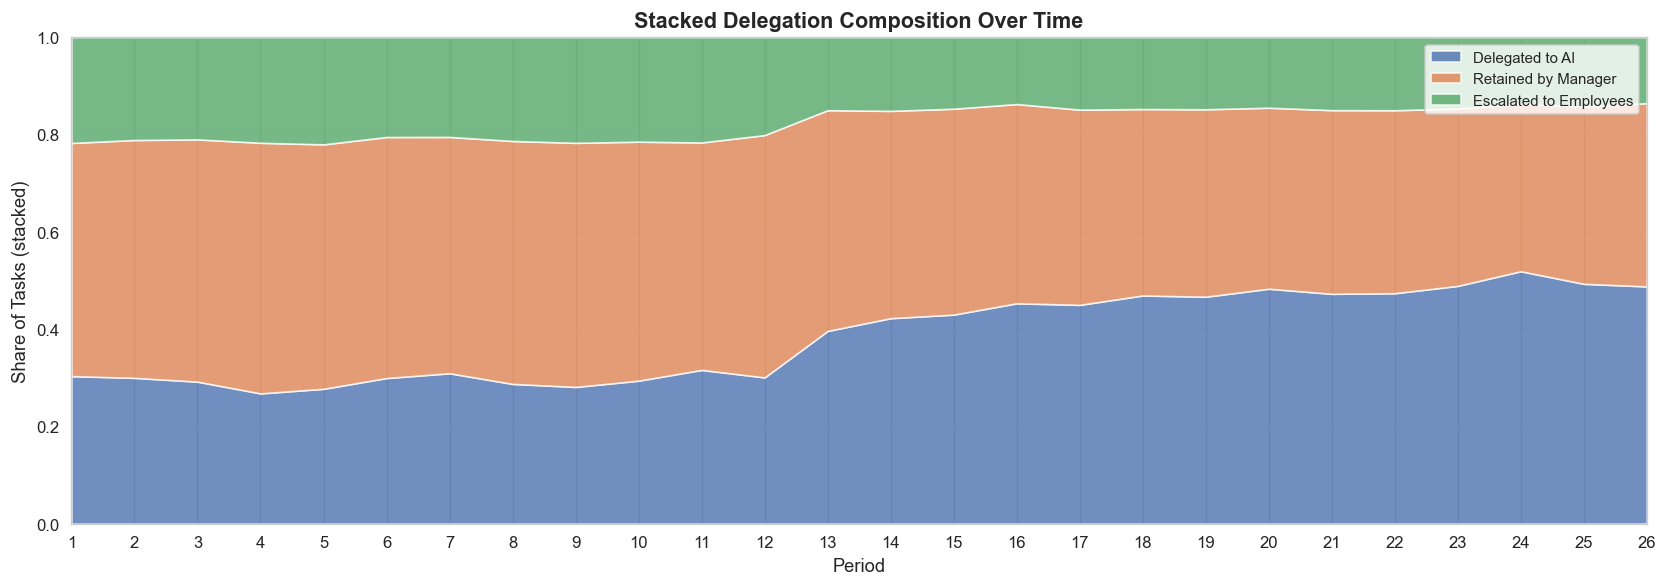

  AI delegation              ρ = +0.912  p = 0.0000  ***
  Manager retention          ρ = -0.886  p = 0.0000  ***
  Employee escalation        ρ = -0.861  p = 0.0000  ***

════════════════════════════════════════════════════════════
✓ Section 5.4 complete: Temporal delegation trends visualised.
════════════════════════════════════════════════════════════


In [74]:
# ============================================================
# 5.4  Task Delegation Over Time
# ============================================================
# Aggregate authority shares across all managers per period,
# then plot temporal evolution with confidence bands.
# ============================================================

print("═══  Delegation Shares Over Time (All Managers)  ═══\n")

# ── 1. Period-level aggregation ──
time_agg = (task_agg
    .groupby("period_id")[["share_authority_ai", "share_authority_mgr", "share_authority_esc"]]
    .agg(["mean", "std", "count"]))

# Flatten multi-index columns
periods_t = time_agg.index.values

ai_mean  = time_agg[("share_authority_ai",  "mean")].values
mgr_mean = time_agg[("share_authority_mgr", "mean")].values
esc_mean = time_agg[("share_authority_esc", "mean")].values

ai_se  = time_agg[("share_authority_ai",  "std")].values / np.sqrt(time_agg[("share_authority_ai",  "count")].values)
mgr_se = time_agg[("share_authority_mgr", "std")].values / np.sqrt(time_agg[("share_authority_mgr", "count")].values)
esc_se = time_agg[("share_authority_esc", "std")].values / np.sqrt(time_agg[("share_authority_esc", "count")].values)

# Summary table
time_summary = pd.DataFrame({
    "Period": periods_t,
    "Delegated to AI (mean)": ai_mean,
    "Retained by Manager (mean)": mgr_mean,
    "Escalated to Employee (mean)": esc_mean,
}).set_index("Period")
display(time_summary.round(4))

# ── 2. Line plot with 95% CI bands ──
fig, ax = plt.subplots(figsize=(14, 5.5))

z = 1.96  # 95% CI

# Delegated to AI
ax.plot(periods_t, ai_mean, "-o", color="#4C72B0", linewidth=2, markersize=5,
        label="Delegated to AI")
ax.fill_between(periods_t, ai_mean - z * ai_se, ai_mean + z * ai_se,
                color="#4C72B0", alpha=0.15)

# Retained by Manager
ax.plot(periods_t, mgr_mean, "-s", color="#DD8452", linewidth=2, markersize=5,
        label="Retained by Manager")
ax.fill_between(periods_t, mgr_mean - z * mgr_se, mgr_mean + z * mgr_se,
                color="#DD8452", alpha=0.15)

# Escalated to Employees
ax.plot(periods_t, esc_mean, "-^", color="#55A868", linewidth=2, markersize=5,
        label="Escalated to Employees")
ax.fill_between(periods_t, esc_mean - z * esc_se, esc_mean + z * esc_se,
                color="#55A868", alpha=0.15)

ax.set_xlabel("Period", fontsize=11)
ax.set_ylabel("Mean Share of Tasks", fontsize=11)
ax.set_title("Task Delegation Over Time: AI vs Manager vs Employee",
             fontsize=13, fontweight="bold")
ax.legend(fontsize=9, loc="best")
ax.set_xlim(periods_t.min() - 0.3, periods_t.max() + 0.3)
ax.set_ylim(0, None)
ax.set_xticks(periods_t)
ax.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ── 3. Stacked area chart ──
fig2, ax2 = plt.subplots(figsize=(14, 5))

ax2.stackplot(periods_t, ai_mean, mgr_mean, esc_mean,
              labels=["Delegated to AI", "Retained by Manager", "Escalated to Employees"],
              colors=["#4C72B0", "#DD8452", "#55A868"], alpha=0.8)

ax2.set_xlabel("Period", fontsize=11)
ax2.set_ylabel("Share of Tasks (stacked)", fontsize=11)
ax2.set_title("Stacked Delegation Composition Over Time",
              fontsize=13, fontweight="bold")
ax2.legend(loc="upper right", fontsize=9)
ax2.set_xlim(periods_t.min(), periods_t.max())
ax2.set_ylim(0, 1.0)
ax2.set_xticks(periods_t)
ax2.grid(axis="y", alpha=0.3)
plt.tight_layout()
plt.show()

# ── 4. Trend test (Spearman rank correlation with period) ──
from scipy.stats import spearmanr

for label, vals in [("AI delegation", ai_mean),
                    ("Manager retention", mgr_mean),
                    ("Employee escalation", esc_mean)]:
    rho, p_val = spearmanr(periods_t, vals)
    sig = "***" if p_val < 0.001 else "**" if p_val < 0.01 else "*" if p_val < 0.05 else "n.s."
    print(f"  {label:25s}  ρ = {rho:+.3f}  p = {p_val:.4f}  {sig}")

print("\n" + "═" * 60)
print("✓ Section 5.4 complete: Temporal delegation trends visualised.")
print("═" * 60)